In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
import json
from tqdm.notebook import tqdm
import numpy as np
import itertools as it
import os
import seaborn as sb

In [2]:
from py_experimenter import utils
datasets_classification = [int(i) for i in utils.get_keyfield_data(utils.load_config(f"config/experiments-fullforests-classification.cfg"))["openmlid"]]
datasets_regression = [int(i) for i in utils.get_keyfield_data(utils.load_config(f"config/experiments-fullforests-regression.cfg"))["openmlid"]]

In [3]:
EPS_LIST = [0.1, 0.01, 0.001]

In [4]:
df_metadata = pd.read_csv("datasets.csv")
df_metadata

openmlid                  name  instances  features  numeric features  \
0           3              kr-vs-kp       3196        36                 0   
1           6                letter      20000        16                16   
2           8       liver-disorders        345         6                 6   
3          12         mfeat-factors       2000       216               216   
4          14         mfeat-fourier       2000        76                76   
..        ...                   ...        ...       ...               ...   
276     42730              us_crime       1994       127               127   
277     42731           house_sales      21613        22                21   
278     42733  Click_prediction_sma      39948        11                 5   
279     42734          okcupid-stem      50789        19                 2   
280     43071   MIP-2016-regression       1090       147               144   

     classes  % missing  
0          2          0  
1         26          0  
2          0          0  
3         10          0  
4         10          0  
..       ...        ...  
276        0         15  
277        0          0  
278        2          0  
279        3         15  
280        0          0  

[281 rows x 7 columns]

In [5]:
def get_dataset_size(openmlid):
    return tuple(df_metadata.query(f"openmlid == {openmlid}")[["instances", "features"]].values[0])

def get_dataset_name(openmlid):
    return df_metadata.query(f"openmlid == {openmlid}")["name"].values[0]

In [6]:
df_base_classification = pd.read_csv("results_classification_base.csv", sep=";")
df_base_regression = pd.read_csv("results_regression_base.csv", sep=";")
for df in [df_base_classification, df_base_regression]:
    for key in ["oob", "val"]:
        df[f"scores_{key}"] = [json.loads(e) for e in df[f"scores_{key}"]]
        df[f"score_{key}_final"] = [np.mean(e[-99:]) for e in df[f"scores_{key}"]]
    df["max_trees_8"] = (8 * 1024 / np.maximum(df["memory_per_tree"], 0.00001)).astype(int)
    df["max_trees_16"] = (16 * 1024 / np.maximum(df["memory_per_tree"], 0.00001)).astype(int)

In [7]:
def get_score_on_curve(curve, number_trees):
    return curve[int(min(len(curve), number_trees)) - 1]

In [8]:
df_base_classification

openmlid  seed  memory_per_tree  train_time_per_tree_in_ns  \
0            3     0         0.000000                     2017.2   
1            3     1         0.000128                     2009.5   
2            3     2         0.000000                     2001.4   
3            3     3         0.000000                     2012.9   
4            3     4         0.000000                     2020.0   
...        ...   ...              ...                        ...   
2204       204     5         0.000984                     1496.0   
2205       204     6         0.061360                     1485.7   
2206       204     7         0.296893                     1480.4   
2207       204     8         0.000000                     1499.2   
2208       204     9         0.312683                     1491.7   

      pred_time_per_tree_in_ns  score_time_per_tree_in_ns  \
0                        473.0                       69.5   
1                        469.0                       69.7   
2                        469.8                       69.2   
3                        470.3                       70.0   
4                        474.5                       70.0   
...                        ...                        ...   
2204                     312.0                       65.7   
2205                     310.1                       67.5   
2206                     306.9                       97.8   
2207                     313.7                       62.8   
2208                     310.8                       80.9   

      pred_time_val_per_tree_in_ns  score_time_val_per_tree_in_ns  \
0                            186.0                           37.5   
1                            186.3                           37.5   
2                            184.4                           37.3   
3                            186.8                           37.9   
4                            186.9                           38.3   
...                            ...                            ...   
2204                         724.1                           34.3   
2205                         718.3                           33.7   
2206                         720.8                           33.1   
2207                         727.8                           34.0   
2208                         730.4                           33.9   

                                             scores_oob  \
0     [0.6583, 0.4882, 0.4018, 0.3423, 0.3059, 0.271...   
1     [0.6525, 0.4797, 0.3923, 0.3342, 0.2931, 0.264...   
2     [0.65, 0.4811, 0.3951, 0.3313, 0.2927, 0.2624,...   
3     [0.6575, 0.4909, 0.403, 0.3462, 0.3059, 0.2754...   
4     [0.6708, 0.4876, 0.3947, 0.3362, 0.2979, 0.266...   
...                                                 ...   
2204  [1.3524, 1.3645, 1.3374, 1.3075, 1.2814, 1.258...   
2205  [1.3436, 1.3601, 1.332, 1.3073, 1.2822, 1.263,...   
2206  [1.3524, 1.3689, 1.3339, 1.3032, 1.2792, 1.263...   
2207  [1.3524, 1.3689, 1.333, 1.2997, 1.2745, 1.2525...   
2208  [1.3524, 1.3667, 1.3317, 1.3061, 1.2771, 1.257...   

                                             scores_val  score_oob_final  \
0     [0.2926, 0.1606, 0.1047, 0.0772, 0.0666, 0.054...           0.0241   
1     [0.2825, 0.1417, 0.0925, 0.0722, 0.0567, 0.052...           0.0238   
2     [0.285, 0.1617, 0.1063, 0.0766, 0.0613, 0.0524...           0.0230   
3     [0.28, 0.1495, 0.0972, 0.078, 0.0623, 0.0549, ...           0.0255   
4     [0.2963, 0.1462, 0.0894, 0.0674, 0.055, 0.0474...           0.0255   
...                                                 ...              ...   
2204  [1.25, 1.2281, 1.1974, 1.1811, 1.1645, 1.1509,...           1.0451   
2205  [1.2237, 1.2047, 1.1711, 1.1505, 1.1418, 1.137...           1.0489   
2206  [1.25, 1.2251, 1.1957, 1.1853, 1.1637, 1.1531,...           1.0446   
2207  [1.25, 1.2222, 1.1957, 1.1758, 1.155, 1.145, 1...           1.0466   
2208  [1.25, 1.2222, 1.2007, 1.1842, 1.1645, 1.1563,...           1.0429   

     

In [9]:
df_base_regression

openmlid  seed  memory_per_tree  train_time_per_tree_in_ns  \
0           8     0         0.000000                     1261.8   
1           8     1         0.000252                     1261.5   
2           8     2         0.000000                     1261.5   
3           8     3         0.000000                     1274.8   
4           8     4         0.000000                     1275.5   
..        ...   ...              ...                        ...   
575     42729     5         7.575664                 13572115.3   
576     42729     6         7.575131                 13329196.6   
577     42729     7         7.595878                 13402645.9   
578     42729     8         7.571332                 13365753.0   
579     42729     9         7.577358                 13434167.3   

     pred_time_per_tree_in_ns  score_time_per_tree_in_ns  \
0                       255.0                       63.2   
1                       256.0                       63.8   
2                       254.1                       61.9   
3                       256.0                       63.3   
4                       256.1                       63.3   
..                        ...                        ...   
575                  370862.2                     3882.4   
576                  368942.0                     4334.0   
577                  360191.7                     3799.8   
578                  359573.4                     4302.5   
579                  372055.9                     4829.2   

     pred_time_val_per_tree_in_ns  score_time_val_per_tree_in_ns  \
0                            71.9                           53.8   
1                            73.3                           55.2   
2                            71.4                           52.7   
3                            72.9                           54.5   
4                            72.7                           54.4   
..                            ...                            ...   
575                      161970.5                         3302.4   
576                      161479.5                         3735.2   
577                      158927.1                         3186.3   
578                      157312.2                         3696.0   
579                      166285.9                         4208.4   

                                            scores_oob  \
0    [0.111163, 0.100853, 0.090091, 0.085005, 0.079...   
1    [0.124229, 0.108082, 0.098663, 0.091072, 0.086...   
2    [0.106581, 0.094522, 0.08387, 0.076417, 0.0726...   
3    [0.113144, 0.098208, 0.08694, 0.080581, 0.0755...   
4    [0.113264, 0.091873, 0.081884, 0.076297, 0.071...   
..                                                 ...   
575  [0.019967, 0.015537, 0.013065, 0.011498, 0.010...   
576  [0.019867, 0.015401, 0.012961, 0.011423, 0.010...   
577  [0.020006, 0.01552, 0.013047, 0.011472, 0.0103...   
578  [0.019915, 0.015478, 0.013026, 0.011476, 0.010...   
579  [0.019875, 0.015455, 0.012987, 0.011418, 0.010...   

                                            scores_val  score_oob_final  \
0    [0.053295, 0.045495, 0.040888, 0.040343, 0.040...         0.040780   
1    [0.08565, 0.073058, 0.062771, 0.060645, 0.0584...         0.048059   
2    [0.077905, 0.053731, 0.051823, 0.050123, 0.047...         0.041337   
3    [0.058225, 0.041385, 0.037468, 0.038312, 0.040...         0.040937   
4    [0.071277, 0.054684, 0.05144, 0.047818, 0.0442...         0.042820   
..                                                 ...              ...   
575  [0.009889, 0.006345, 0.005082, 0.004457, 0.004...         0.003155   
576  [0.009905, 0.006393, 0.005099, 0.004464, 0.004...         0.003139   
577  [0.009798, 0.006294, 0.005005, 0.00437, 0.0040...         0.003175   
578  [0.010067, 0.006448, 0.005127, 0.004481, 0.004...         0.003159   
579  [0.009826, 0.006332, 0.005075, 0.004483, 0.004...         0.003148   

     score_val_final  max_trees_8  max_trees_16  
0           0.

# RQ1: Appropriateness of OOB

In [10]:
def create_admissibility_plots(df_base, group_attributes, problem_type):
    domain_eps = EPS_LIST
    fig1, axs1 = plt.subplots(1, len(domain_eps), figsize=(4 * len(domain_eps), 3))
    fig2, axs2 = plt.subplots(1, len(domain_eps), figsize=(4 * len(domain_eps), 3))
    
    for eps, ax1, ax2 in zip(domain_eps, axs1, axs2):
        violations = []
        eps_oob = eps
        eps_test = eps
        convergence_indices_oob = []
        convergence_indices_test = []
        oob_performance_at_test_convergence = []
        test_performance_at_oob_convergence = []
        for key, df_key in df_base.groupby(group_attributes):

            convergence_indices_oob_key = []
            convergence_indices_test_key = []
            oob_performance_at_test_convergence_key = []
            test_performance_at_oob_convergence_key = []
            for j, row in df_key.iterrows():
                oob_gaps = np.array(row["scores_oob"]) - row["score_oob_final"]
                oob_violations = np.where(oob_gaps > eps_oob)[0]
                test_gaps = np.array(row["scores_val"]) - row["score_val_final"]
                test_violations = np.where(test_gaps > eps_test)[0]
                convergence_indices_oob_key.append(np.max(oob_violations) + 1 if len(oob_violations) > 0 else 1)
                convergence_indices_test_key.append(np.max(test_violations) + 1 if len(test_violations) > 0 else 1)
                oob_performance_at_test_convergence_key.append(oob_gaps[convergence_indices_test_key[-1]])
                test_performance_at_oob_convergence_key.append(test_gaps[convergence_indices_oob_key[-1]])
            convergence_indices_oob.append(np.mean(convergence_indices_oob_key))
            convergence_indices_test.append(np.mean(convergence_indices_test_key))
            if convergence_indices_oob[-1] < convergence_indices_test[-1]:
                print(f"Violation for key {key} on eps = {eps}. Dataset shape is {get_dataset_size(key if type(key) == int else key[0])}")
                violations.append(key) # append key info like openmlid (maybe with seed)
            oob_performance_at_test_convergence.append(np.mean(oob_performance_at_test_convergence_key))
            test_performance_at_oob_convergence.append(np.mean(test_performance_at_oob_convergence_key))
        print(f"Total number of violations on {problem_type} with {eps}: {len(violations)} ({np.round(100 * len(violations) / len(convergence_indices_oob), 2)}%). Datasets: {violations}")

        ax = ax1
        #means = (np.mean(convergence_indices_oob), np.mean(convergence_indices_test))
        ax.scatter(convergence_indices_oob, convergence_indices_test, s=10, alpha=0.5)
        tolerance = 0.1 * max(convergence_indices_test)
        #ax.plot([0, max(convergence_indices_test)], [tolerance, tolerance + max(convergence_indices_test)], color="blue", linestyle="--", linewidth=1)
        ax.plot([0, max(convergence_indices_test)], [0, max(convergence_indices_test)], color="black", linestyle="--", linewidth=1)
        ax.plot([0, max(convergence_indices_oob)], [0, 0.368 * max(convergence_indices_oob)], color="blue", linestyle="--", linewidth=1)
        ax.plot([0, max(convergence_indices_oob)], [0, 0.1 * max(convergence_indices_oob)], color="red", linestyle="--", linewidth=1)
        ax.set_ylim([0, max(convergence_indices_test) + 0.01])
        ax.set_xlabel(f"# trees for {eps_oob}-convergence\non OOB curve")
        ax.set_ylabel(f"# trees for {eps_test}-convergence\non validation curve")
        ax.set_title(f"$\\varepsilon = {eps}$")

        ax = ax2
        ax.scatter(oob_performance_at_test_convergence, test_performance_at_oob_convergence, s=10, alpha=0.5)
        ax.axvline(eps_oob, color="red", linestyle="--", linewidth=1)
        ax.axhline(eps_test, color="red", linestyle="--", linewidth=1)
        ax.plot([0, max(test_performance_at_oob_convergence)], [0, max(test_performance_at_oob_convergence)], color="black", linestyle="--", linewidth=1)
        ax.set_xlabel(f"OOB gap at convergence size\nin validation curve")
        ax.set_ylabel(f"Validation gap at convergence size\nin OOB curve")
        ax.set_title(f"$\\varepsilon = {eps}$")
    fig1.tight_layout()
    fig1.savefig(f"plots/oob_suitability_{problem_type}_sizes_{'_'.join(group_attributes)}.pdf", bbox_inches="tight")
    fig2.tight_layout()
    fig2.savefig(f"plots/oob_suitability_{problem_type}_scores_{'_'.join(group_attributes)}.pdf", bbox_inches="tight")
    plt.show()

In [91]:
def plot_curves(df_base):
    for openmlid, df_dataset in tqdm(df_base.groupby("openmlid")):
        min_num_oob_scores = 2000#min([len(e) for e in df_dataset["scores_oob"]])
        min_num_test_scores = 2000#min([len(e) for e in df_dataset["scores_oob"]])
        mean_oob_curve = np.array([e[:min_num_oob_scores] for e in df_dataset["scores_oob"]])
        mean_test_curve = np.array([e[:min_num_test_scores] for e in df_dataset["scores_val"]])
        fig, ax = plt.subplots(figsize=(5, 3))
        ax.plot(range(mean_oob_curve.shape[1]), np.mean(mean_oob_curve, axis = 0), label="OOB score")
        ax.plot(range(mean_test_curve.shape[1]), np.mean(mean_test_curve, axis = 0), label="Validation score")
        ax.set_xlabel("Number of Trees")
        ax.set_ylabel("Brier Score")
        ax.set_title(f"{openmlid} ({get_dataset_name(openmlid)})")
        ax.legend()
        fig.tight_layout()
        fig.savefig(f"plots/curves/{openmlid}.pdf", bbox_inches="tight")
        plt.show()

## Classification

Total number of violations on classification with 0.1: 0 (0.0%). Datasets: []
Violation for key 485 on eps = 0.01. Dataset shape is (48, 4)
Total number of violations on classification with 0.01: 1 (0.45%). Datasets: [485]
Violation for key 485 on eps = 0.001. Dataset shape is (48, 4)
Violation for key 679 on eps = 0.001. Dataset shape is (1024, 2)
Violation for key 1464 on eps = 0.001. Dataset shape is (748, 4)
Violation for key 41157 on eps = 0.001. Dataset shape is (100, 10000)
Total number of violations on classification with 0.001: 4 (1.81%). Datasets: [485, 679, 1464, 41157]


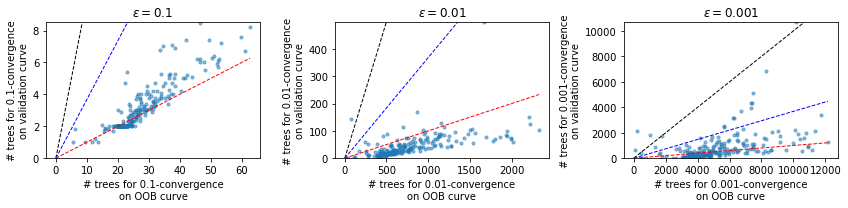

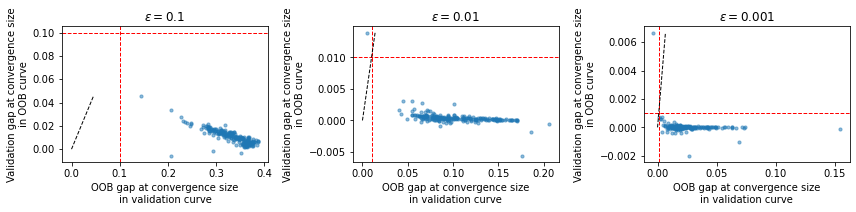

Total number of violations on regression with 0.1: 0 (0.0%). Datasets: []
Total number of violations on regression with 0.01: 0 (0.0%). Datasets: []
Violation for key 190 on eps = 0.001. Dataset shape is (61, 2)
Total number of violations on regression with 0.001: 1 (1.72%). Datasets: [190]


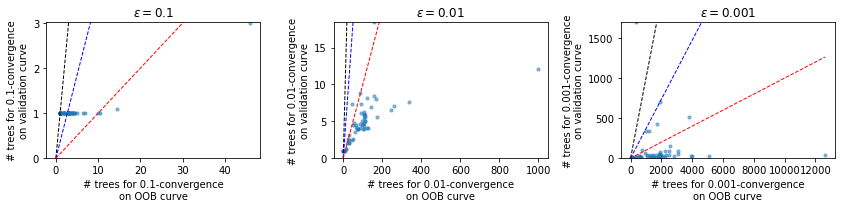

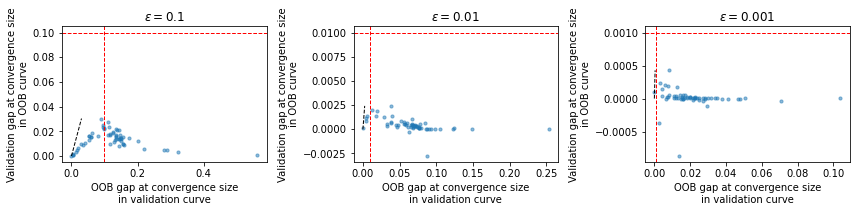

In [92]:
create_admissibility_plots(df_base_classification, ["openmlid"], "classification")
create_admissibility_plots(df_base_regression, ["openmlid"], "regression")
#create_admissibility_plots(df_base_classification, ["openmlid", "seed"], "classification")

  0%|          | 0/221 [00:00<?, ?it/s]

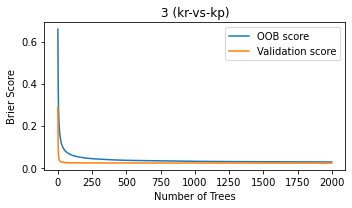

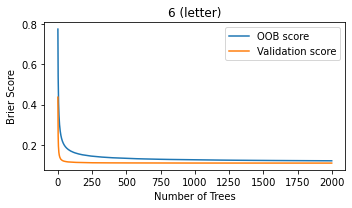

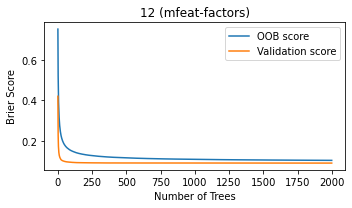

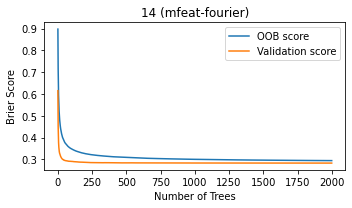

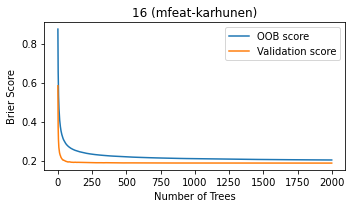

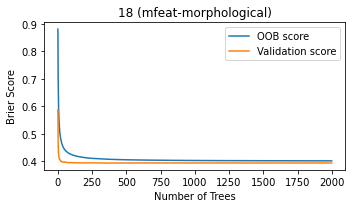

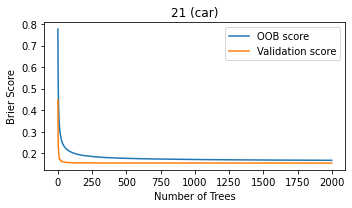

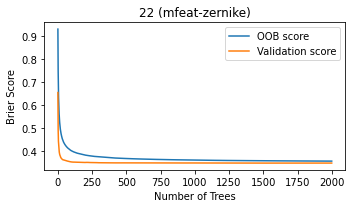

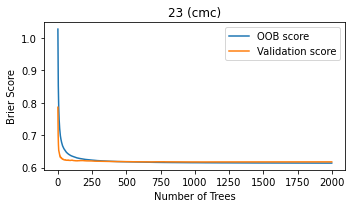

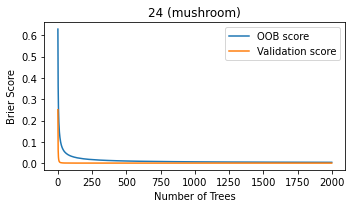

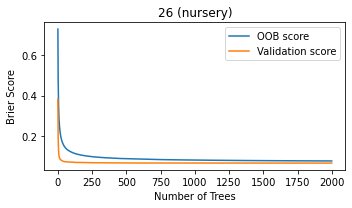

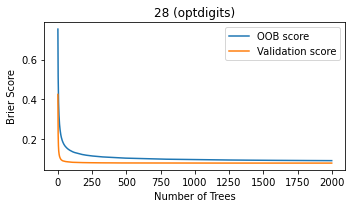

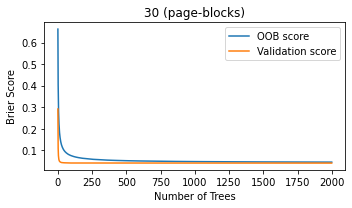

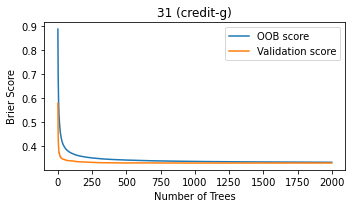

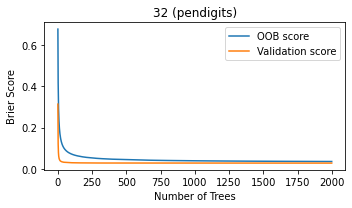

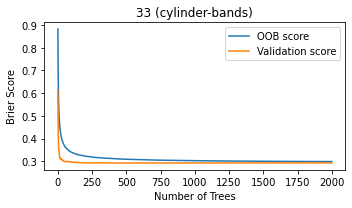

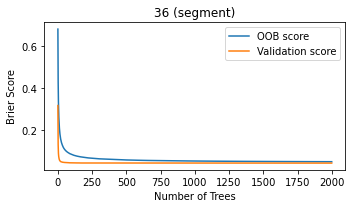

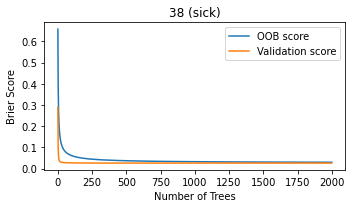

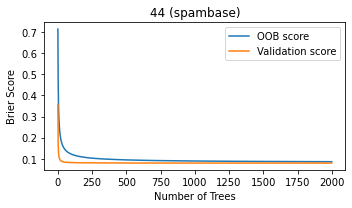

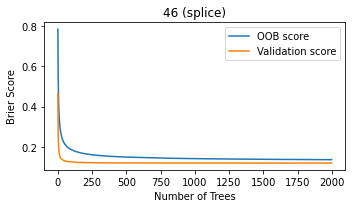

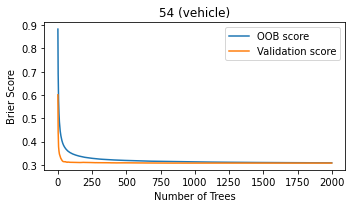

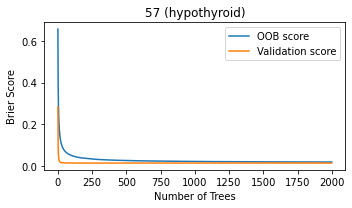

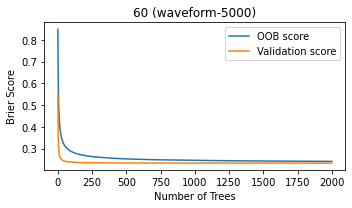

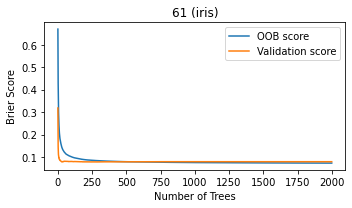

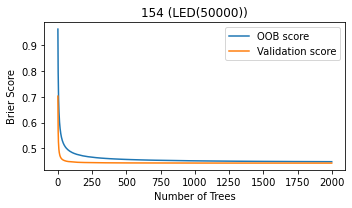

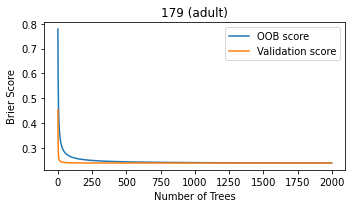

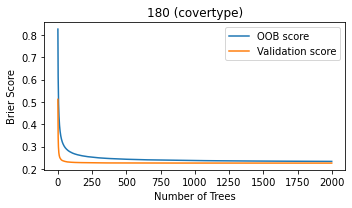

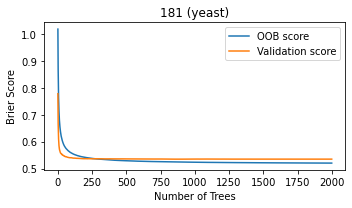

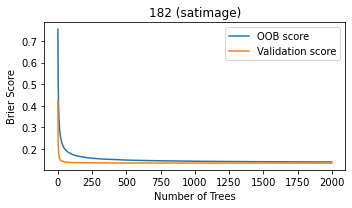

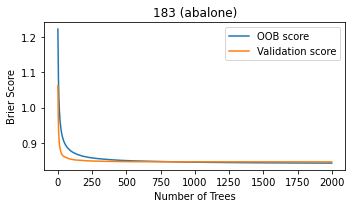

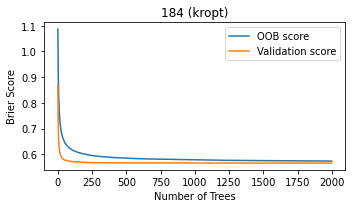

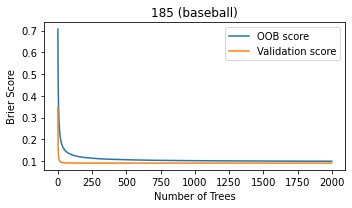

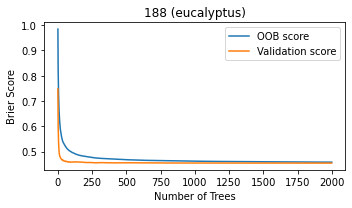

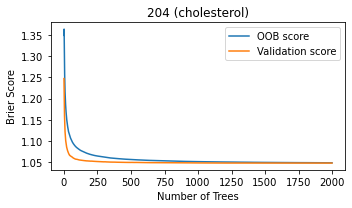

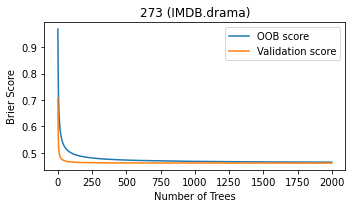

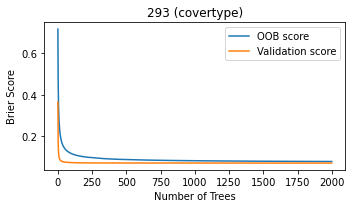

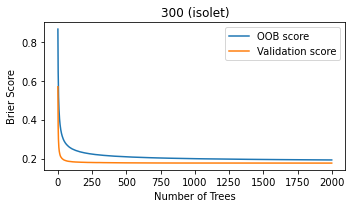

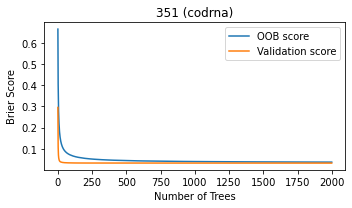

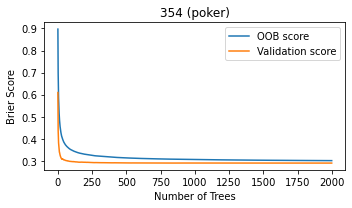

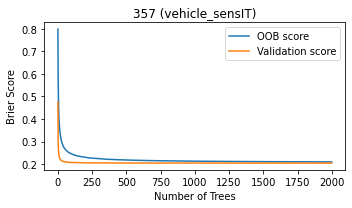

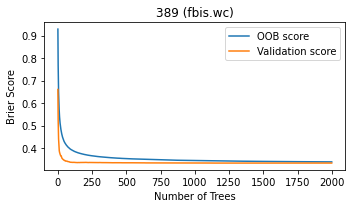

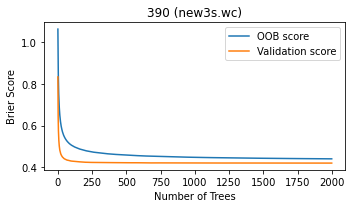

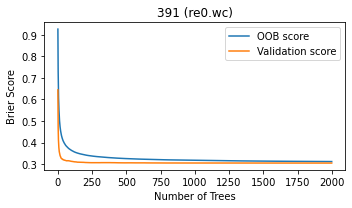

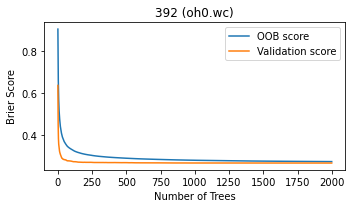

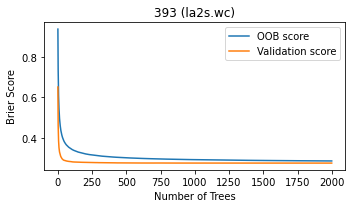

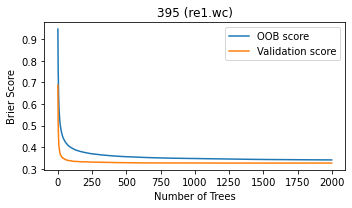

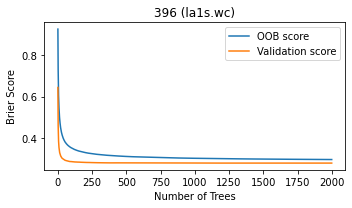

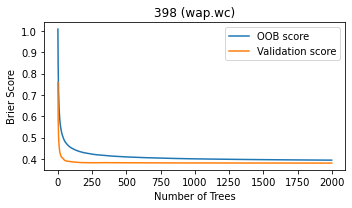

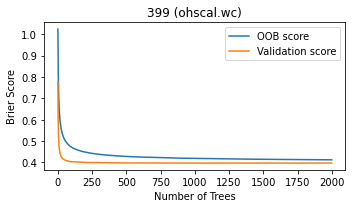

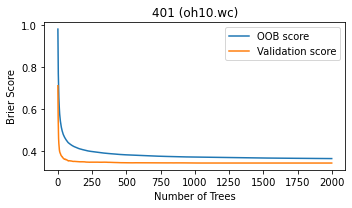

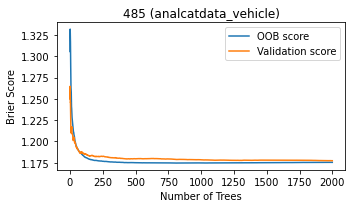

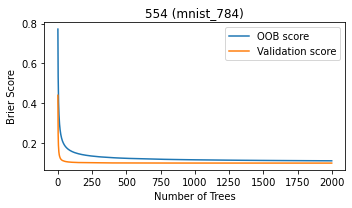

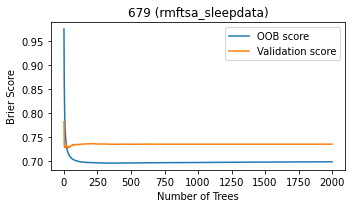

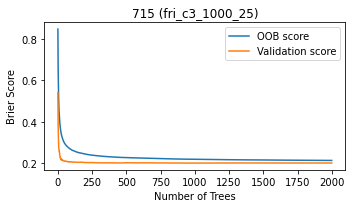

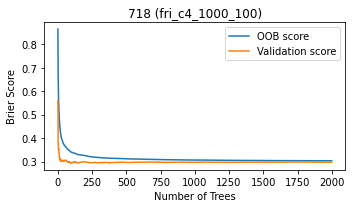

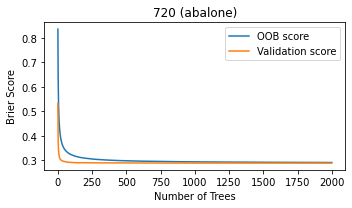

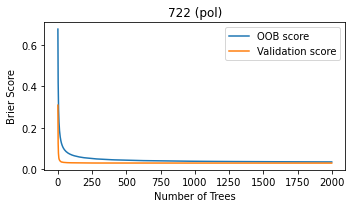

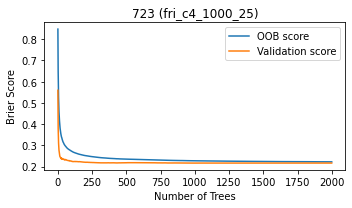

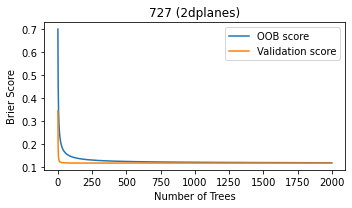

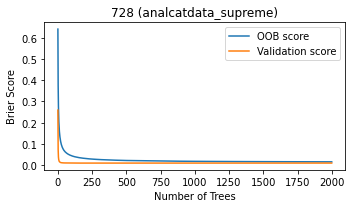

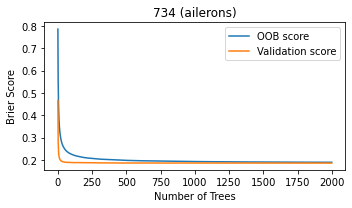

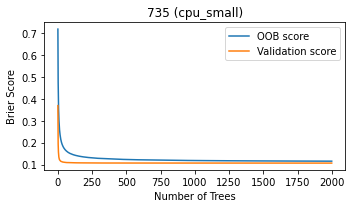

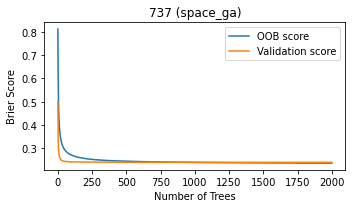

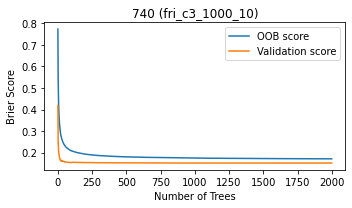

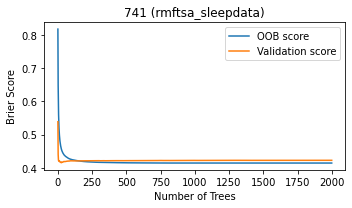

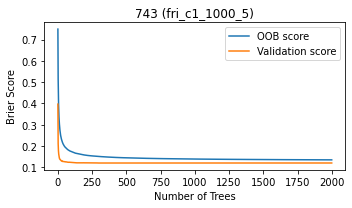

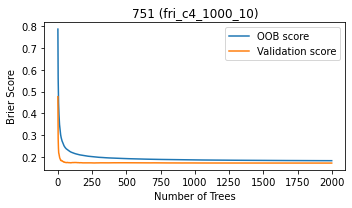

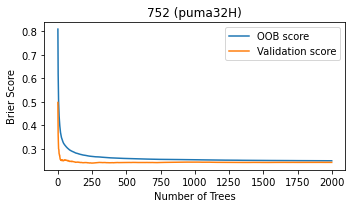

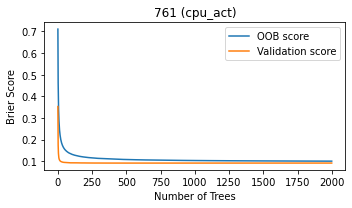

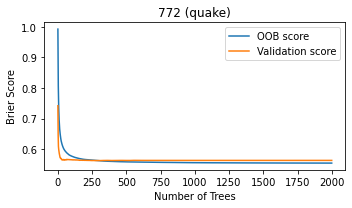

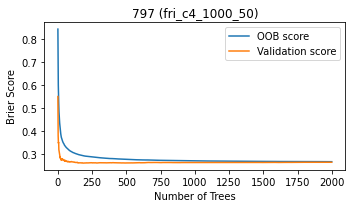

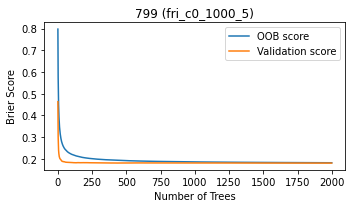

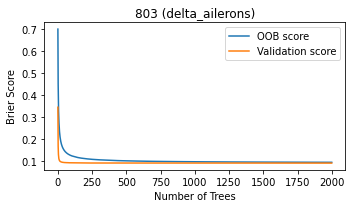

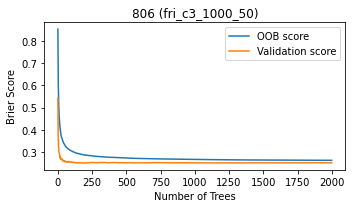

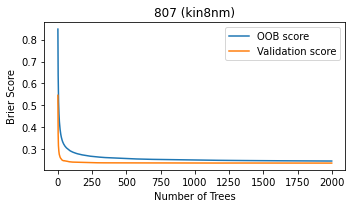

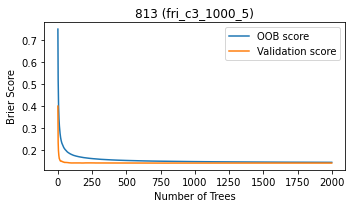

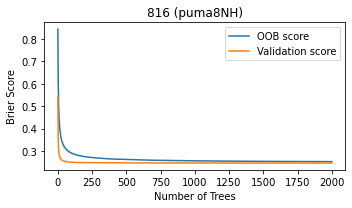

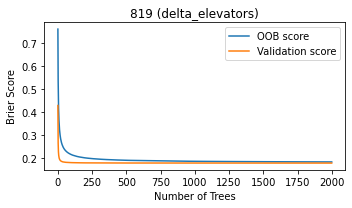

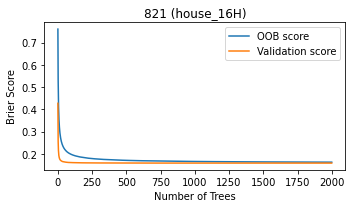

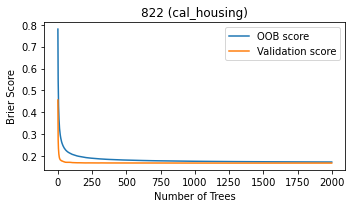

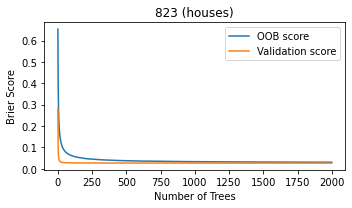

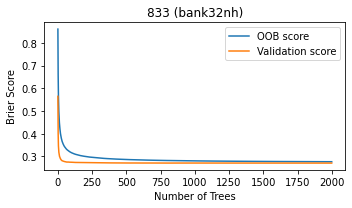

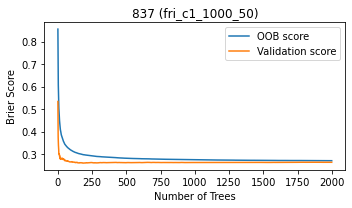

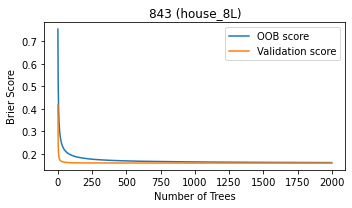

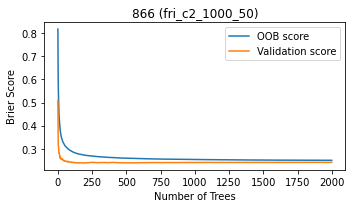

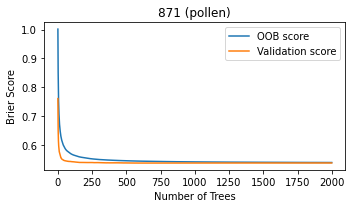

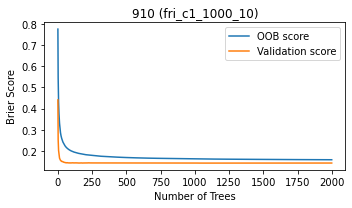

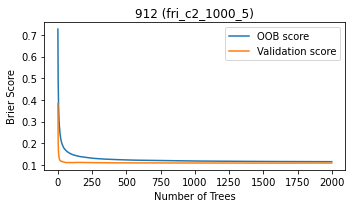

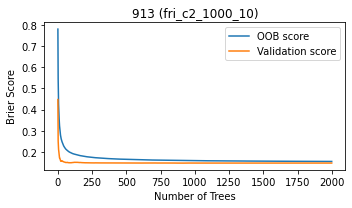

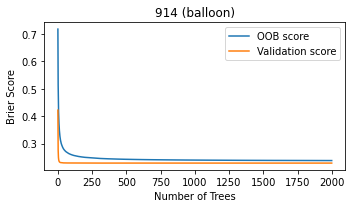

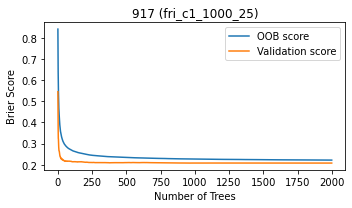

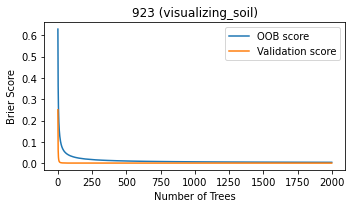

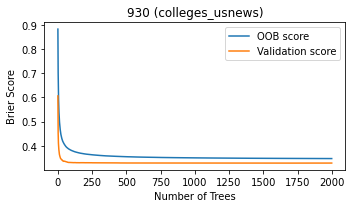

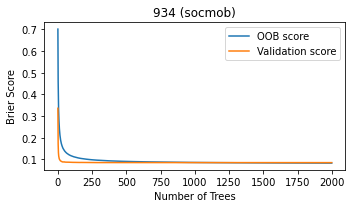

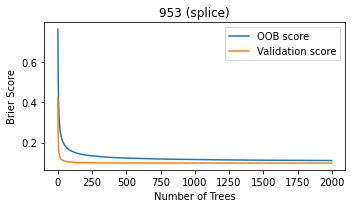

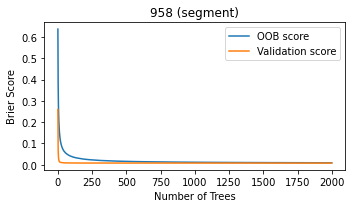

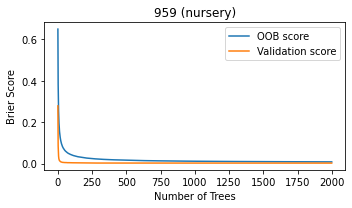

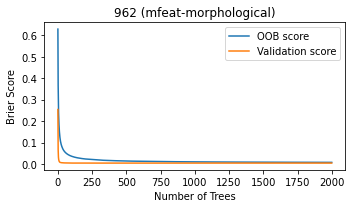

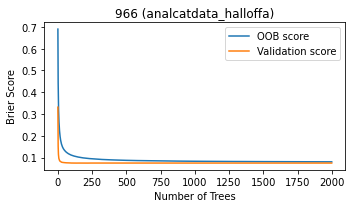

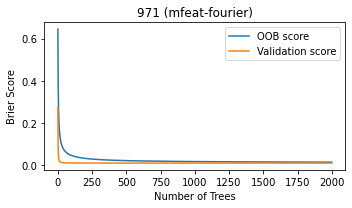

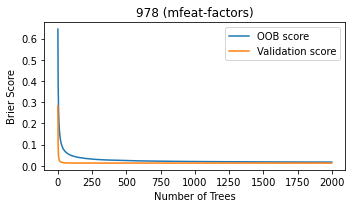

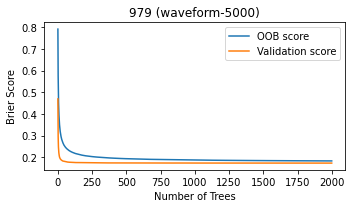

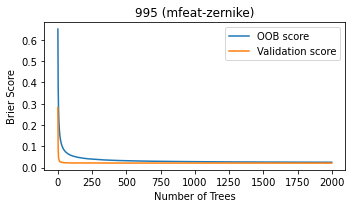

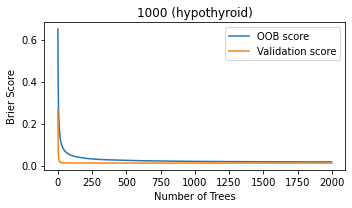

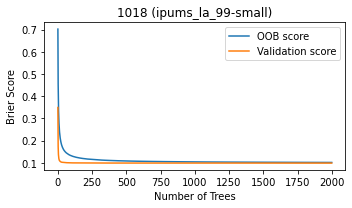

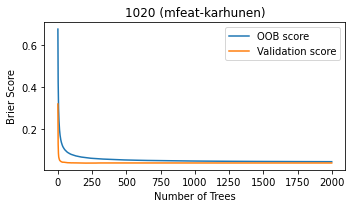

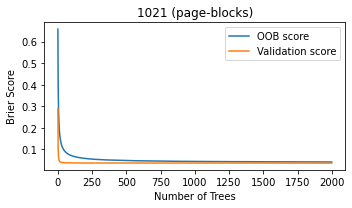

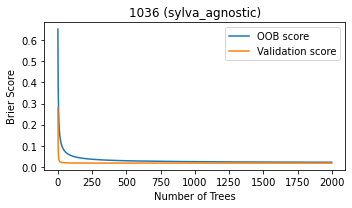

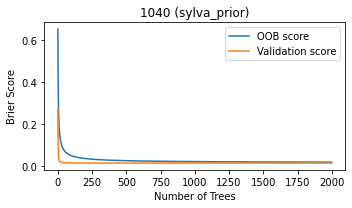

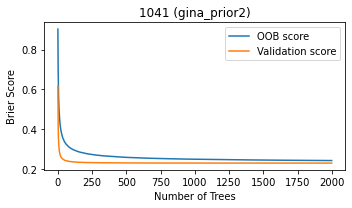

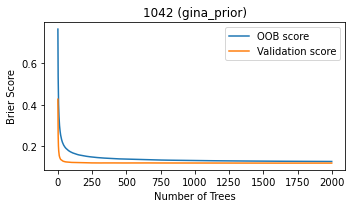

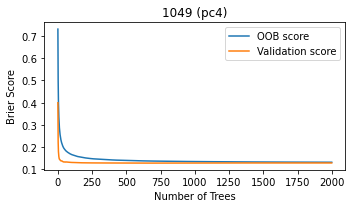

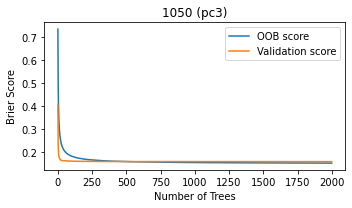

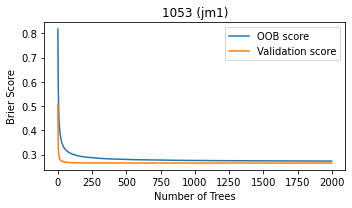

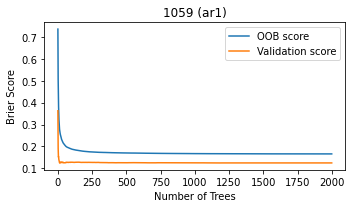

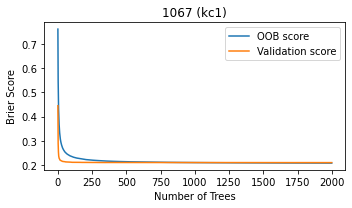

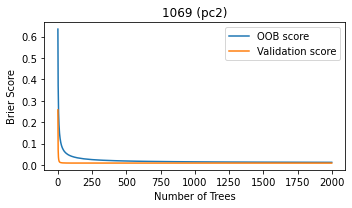

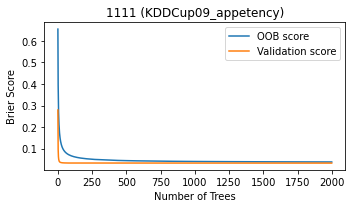

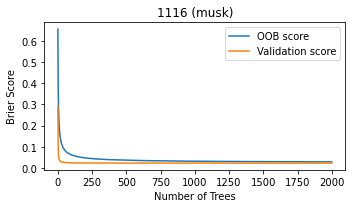

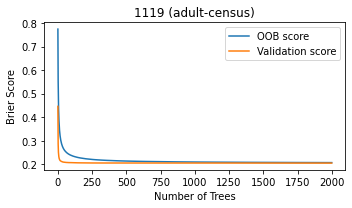

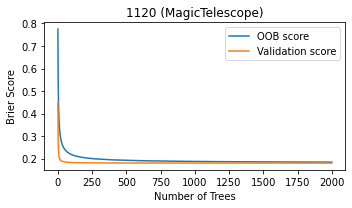

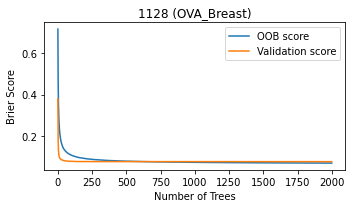

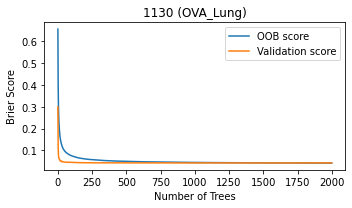

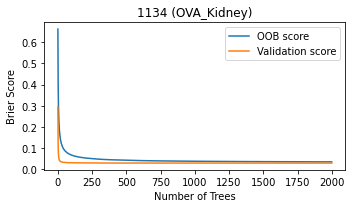

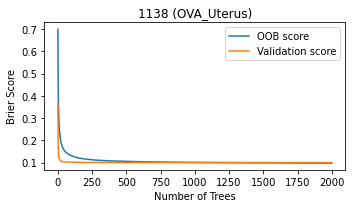

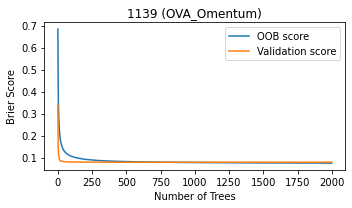

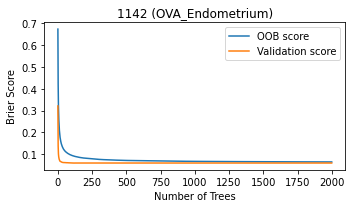

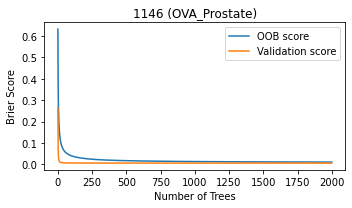

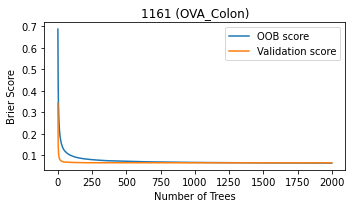

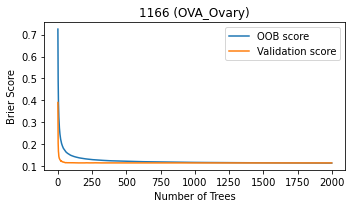

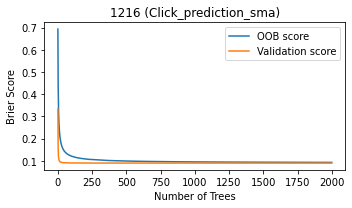

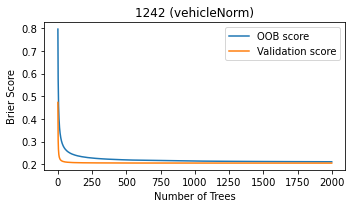

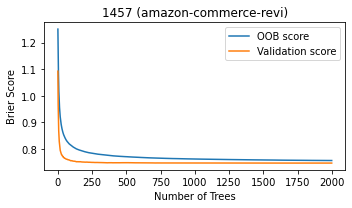

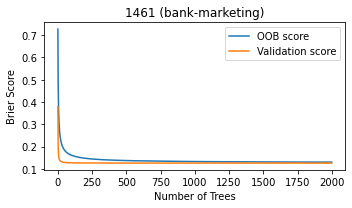

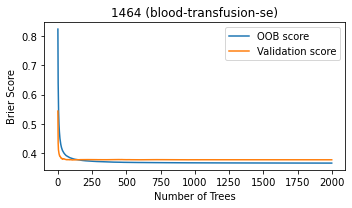

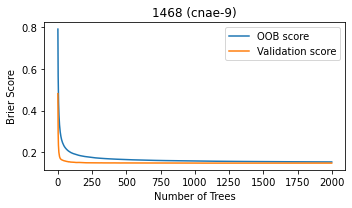

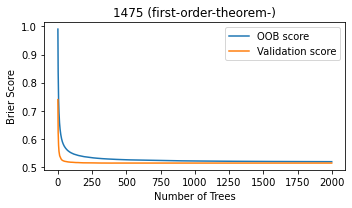

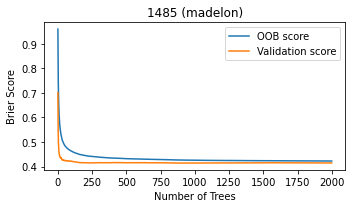

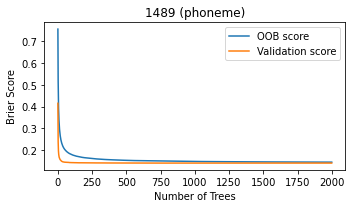

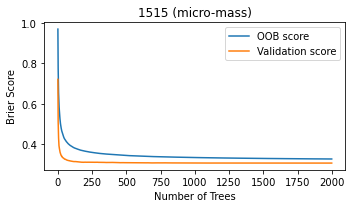

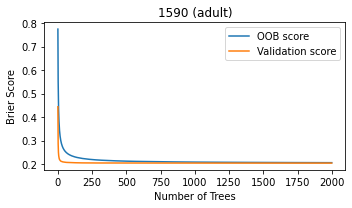

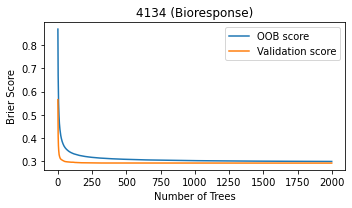

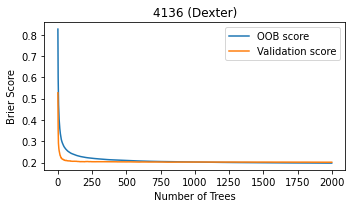

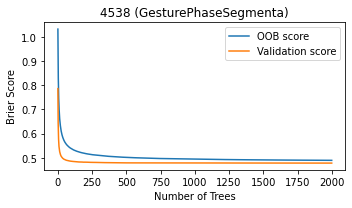

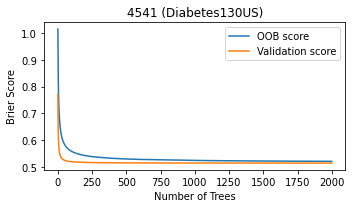

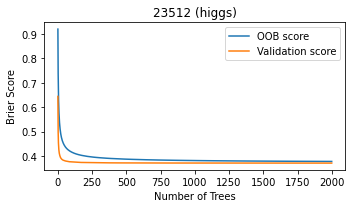

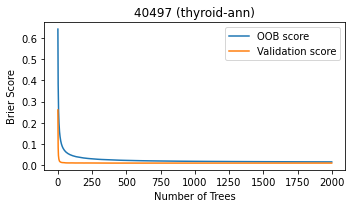

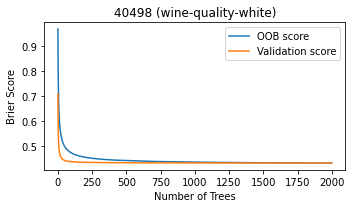

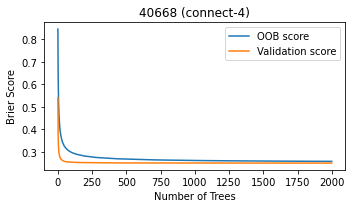

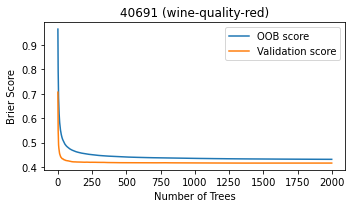

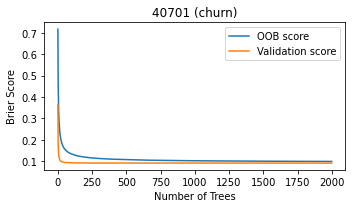

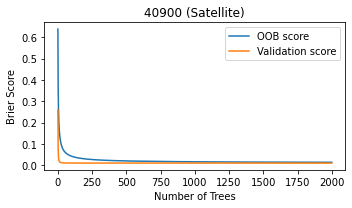

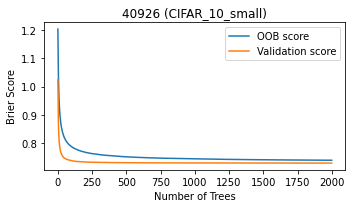

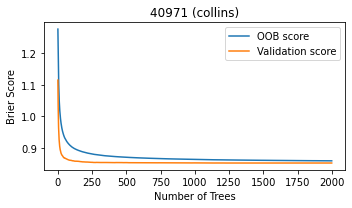

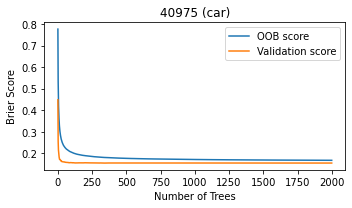

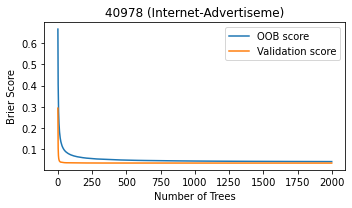

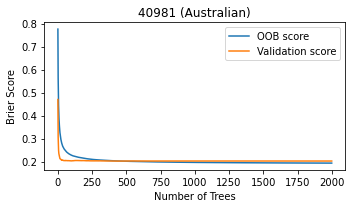

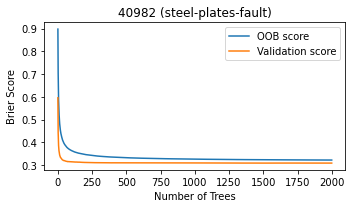

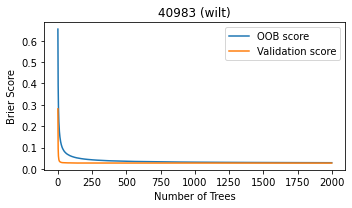

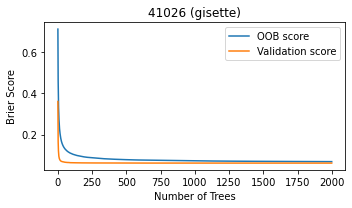

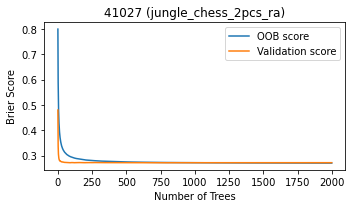

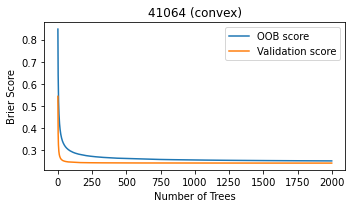

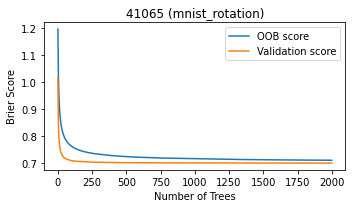

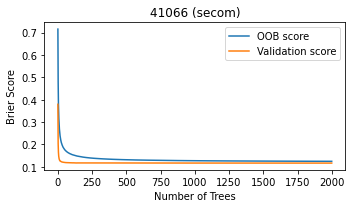

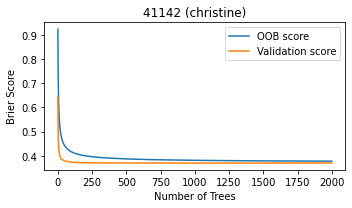

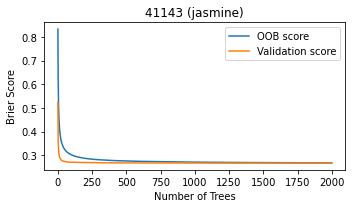

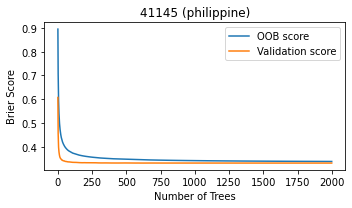

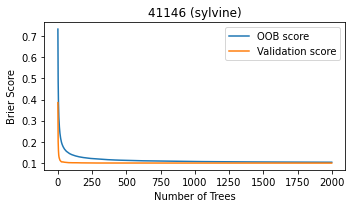

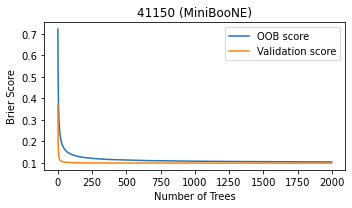

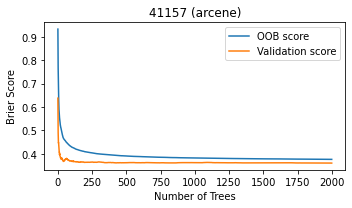

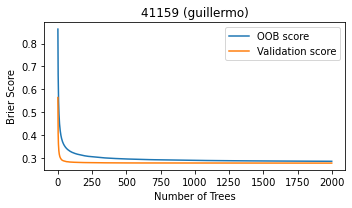

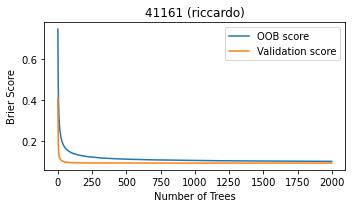

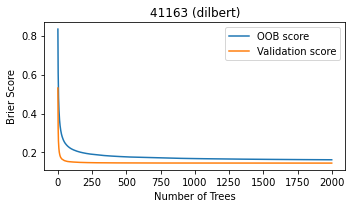

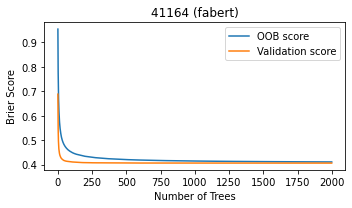

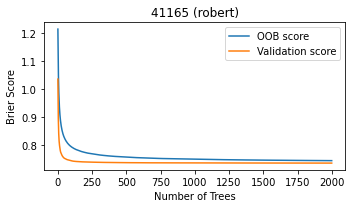

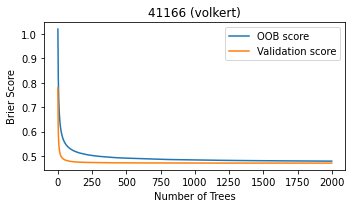

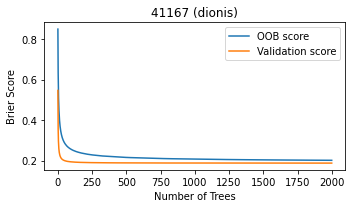

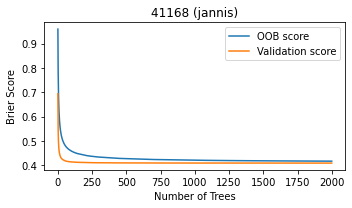

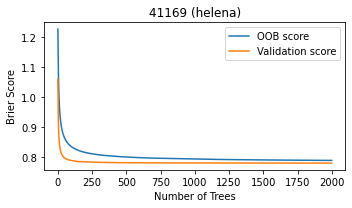

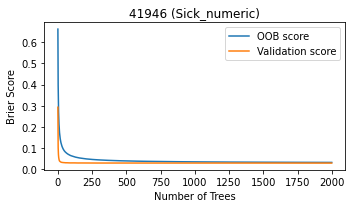

/home/felix/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  """
/home/felix/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  


IndexError: tuple index out of range

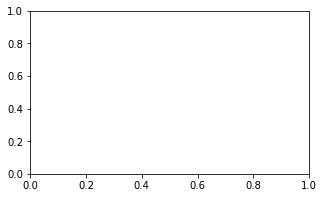

In [12]:
plot_curves(df_base_classification)

## Regression

Violation for key 190 on eps = 0.001. Dataset shape is (61, 2)


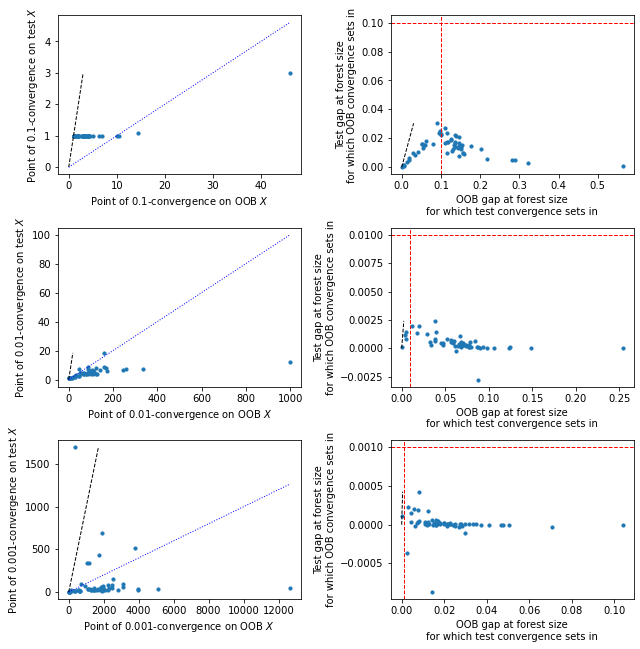

Violation for key (190, 1) on eps = 0.001. Dataset shape is (61, 2)
Violation for key (190, 2) on eps = 0.001. Dataset shape is (61, 2)
Violation for key (190, 3) on eps = 0.001. Dataset shape is (61, 2)
Violation for key (190, 4) on eps = 0.001. Dataset shape is (61, 2)
Violation for key (190, 5) on eps = 0.001. Dataset shape is (61, 2)
Violation for key (190, 6) on eps = 0.001. Dataset shape is (61, 2)
Violation for key (190, 7) on eps = 0.001. Dataset shape is (61, 2)
Violation for key (190, 8) on eps = 0.001. Dataset shape is (61, 2)
Violation for key (191, 0) on eps = 0.001. Dataset shape is (194, 32)
Violation for key (191, 4) on eps = 0.001. Dataset shape is (194, 32)
Violation for key (191, 5) on eps = 0.001. Dataset shape is (194, 32)
Violation for key (191, 6) on eps = 0.001. Dataset shape is (194, 32)
Violation for key (194, 8) on eps = 0.001. Dataset shape is (303, 13)
Violation for key (204, 2) on eps = 0.001. Dataset shape is (303, 13)
Violation for key (231, 1) on eps = 

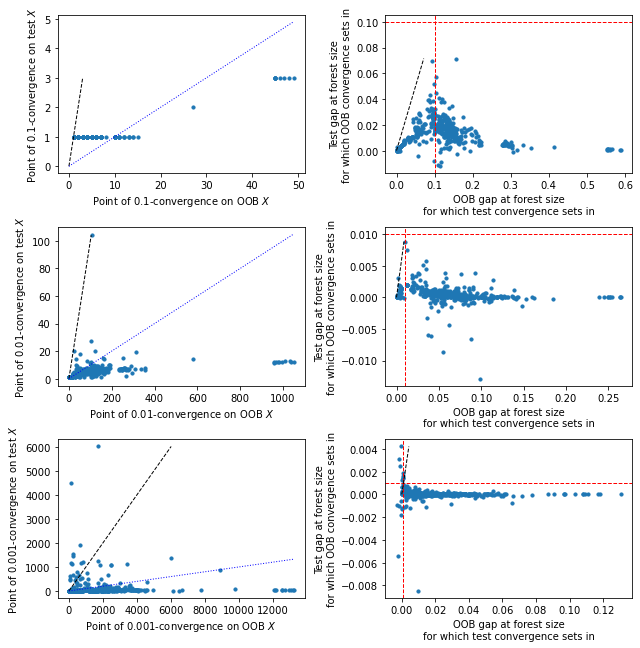

In [28]:
create_plots(df_base_regression, ["openmlid"], "regression")
create_plots(df_base_regression, ["openmlid", "seed"], "regression")

In [ ]:
plot_curves(df_base_regression)

# RQ2: HPO
## Internal Preliminaries

In [9]:
def get_results_for_number_of_trees(df_base, num_trees, target_type = None, suffix = ""):
    
    # pre-process argument
    if type(num_trees) == int:
        df_num_trees = df_base[["openmlid", "seed"]].copy()
        df_num_trees["num_trees"] = num_trees
        df_num_trees["target_type"] = target_type
    else:
        df_num_trees = num_trees
    
    df_analysis = df_base.merge(df_num_trees, on=["openmlid", "seed"])
    results = {}
    results["score_oob" + suffix] = [get_score_on_curve(curve, num_trees) for curve, num_trees in zip(df_analysis["scores_oob"], df_analysis["num_trees"])]
    results["score_val" + suffix] = [get_score_on_curve(curve, num_trees) for curve, num_trees in zip(df_analysis["scores_val"], df_analysis["num_trees"])]
    results["gap_oob" + suffix] = np.round([score - final_score for score, final_score in zip(results["score_oob" + suffix], df_analysis["score_oob_final"])], 5)
    results["gap_val" + suffix] = np.round([score - final_score for score, final_score in zip(results["score_val" + suffix], df_analysis["score_val_final"])], 5)
    results["time_train" + suffix] = [time * num_trees for time, num_trees in zip(df_analysis["train_time_per_tree_in_ns"], df_analysis["num_trees"])]
    
    if "target_type" in df_num_trees.columns:
        times_prediction = [t1 if target_type == "oob" else t2 for target_type, t1, t2 in zip(df_analysis["target_type"], df_analysis["pred_time_per_tree_in_ns"], df_analysis["pred_time_val_per_tree_in_ns"])]
        times_score = [t1 if target_type == "oob" else t2 for target_type, t1, t2 in zip(df_analysis["target_type"], df_analysis["score_time_per_tree_in_ns"], df_analysis["score_time_val_per_tree_in_ns"])]
        results["time_pred" + suffix] = [time * num_trees for time, num_trees in zip(times_prediction, df_analysis["num_trees"])]
        results["time_score" + suffix] = [time * num_trees for time, num_trees in zip(times_score, df_analysis["num_trees"])]
        if "reasoning_time" in df_num_trees.columns:
            results["time_reason" + suffix] = [time * num_trees * 1000 for time, num_trees in zip(df_analysis["reasoning_time"], df_analysis["num_trees"])]
    
    lengths = [len(v) for v in results.values()]
    if min(lengths) != max(lengths or min(lengths) != len(df_num_trees)):
        raise ValueError(f"Dataframe do not have same length. df_num_trees has length {len(df_num_trees)} but results are of length {results['score_oob' + suffix]}")
    
    df_final = pd.concat([df_analysis[df_num_trees.columns].rename(columns={"num_trees": "num_trees" + suffix}), pd.DataFrame(results)], axis=1)
    return df_final

In [10]:
def compute_sensitivity_results(df_base, problem_type):
    
    # first create a summary for each dataset (this is for robustness in case that this part crashes)
    for openmlid in tqdm(sorted(pd.unique(df_base["openmlid"]))):
        try:
            out_file = f"sensitivity/{openmlid}_summary.csv"
            if not os.path.exists(out_file):
                df_dataset_bare = pd.read_csv(f"sensitivity/{openmlid}.csv",)
                df_dataset_summarized = get_results_for_number_of_trees(df_base, df_dataset_bare).groupby(["openmlid", "target_type", "epsilon", "w_min", "delta", "c", "bootstrap_repeats"]).mean().reset_index()#[["openmlid", "target_type", "epsilon", "w_min", "delta", "c", "bootstrap_repeats", "num_trees", "gap_oob", "gap_val", "reasoning_time_per_tree_in_ns"]]
                df_dataset_summarized.to_csv(out_file, index=False)
            
        except FileNotFoundError:
            print(f"No sensitivity results found for {openmlid}")
            pass
    
    # now aggregate the dataset-wise summaries to a single one
    for key in ["oob", "val"]:
        summary_out = f"results_{problem_type}_sensitivity_summary_{key}.csv"
        if not os.path.exists(summary_out):
            sensitivity_dfs = []
            for openmlid in tqdm(sorted(pd.unique(df_base["openmlid"]))):
                sensitivity_dfs.append(pd.read_csv(f"sensitivity/{openmlid}_summary.csv").query(f"target_type == '{key}'"))
            pd.concat(sensitivity_dfs).to_csv(summary_out, index=False)

In [11]:
# in an initial run, this can take long (apprx. 30 minutes on a standard machine)
# required disk space: around 7GB
# required memory: around 6GB (exclusively for running this cell)
compute_sensitivity_results(df_base_classification, "classification")

  0%|          | 0/221 [00:00<?, ?it/s]

In [12]:
compute_sensitivity_results(df_base_regression, "regression")

  0%|          | 0/58 [00:00<?, ?it/s]

## Why choosing $b = 0$ is reasonable

### Performance Change with Bootstrapping is Marginal

In [13]:
def plot_sensitivity_in_bootstrapping(df_sensitivity, problem_type, criterion):
    
    file = f"plots/sensitivity/{problem_type}/{criterion}/bootstrap_analysis.pdf"
    
    if os.path.exists(file):
        return
    
    criterion_name = "OOB" if criterion == "oob" else "validation"
    epsilons = []
    deltas = []
    gap_ranges = []
    gap_ranges_admissible = []
    for key, df_key in tqdm(df_sensitivity.groupby(["openmlid", "target_type", "epsilon", "w_min", "delta", "c"])):
        eps = key[2]
        epsilons.append(eps)
        deltas.append(key[-2])
        gap_range = np.max(df_key["gap_" + criterion]) - np.min(df_key["gap_" + criterion])
        if np.isnan(gap_range):
            print(gap_range)
        gap_ranges.append(gap_range)
        if np.min(df_key["gap_" + criterion]) <= eps:
            gap_ranges_admissible.append(gap_range)
            
    gap_ranges = np.array(gap_ranges)
    epsilons = np.array(epsilons)
    deltas = np.array(deltas)
    
    print(f"Determined {len(gap_ranges)} for {problem_type}/{criterion}")
    
    fig, axs = plt.subplots(1, 3, figsize=(15, 3), gridspec_kw={'width_ratios': [2, 1.2 ,2.6]})
    
    ax = axs[0]
    sb.ecdfplot(data=gap_ranges, ax = ax, label="all configs")
    sb.ecdfplot(data=gap_ranges_admissible, ax = ax, label="admissible configs")
    ax.axvline(0.001, color="black", linestyle="--", linewidth=1)
    ax.set_xlim([0, 0.01])
    ax.set_xlabel("Gap Range")
    ax.set_title(f"Empirical Cumulative Distribution of Gap Ranges\nBased on the {criterion_name} curve for {problem_type}")
    ax.legend()
    
    ax = axs[1]
    boxes = []
    epsilon_domain = EPS_LIST
    for i, eps in enumerate(epsilon_domain):
        mask = epsilons == eps
        boxes.append(gap_ranges[mask])
        ax.plot([i+ 0.8, i + 1.2], [eps, eps], color="black", linestyle="--")
    ax.boxplot(boxes, whis=[0, 100])
    ax.set_xticklabels(epsilon_domain)
    
    ax.set_xlabel("$\\varepsilon$")
    ax.set_ylabel("Gap Range")
    ax.set_yscale("log")
    ax.set_ylim([10**-6.2, 10**-.9])
    ax.set_yticks([10**-i for i in range(1, 7)])
    ax.set_yticklabels(["$10^{-" + str(i) + "}$" for i in range(1, 7)])
    ax.set_title(f"Distribution of Gap Ranges by $\\varepsilon$\nBased on the {criterion_name} curve for {problem_type}")
    
    ax = axs[2]
    deltas_domain = sorted(np.unique(deltas))
    ranges_by_delta = [gap_ranges[deltas == delta] for delta in deltas_domain]
    ax.boxplot(ranges_by_delta, whis=[0,100])
    ax.set_xticklabels(deltas_domain, rotation=90)
    ax.set_xlabel("$\delta$")
    ax.set_ylabel("Gap Range")
    ax.set_title(f"Distribution of Gap Ranges by extrapolation window length $\\delta$\nBased on the {criterion_name} curve for {problem_type}")
    ax.set_yscale("log")
    ax.set_ylim([10**-6.2, 10**-.9])
    ax.set_yticks([10**-i for i in range(1, 7)])
    ax.set_yticklabels(["$10^{-" + str(i) + "}$" for i in range(1, 7)])
    print(np.count_nonzero(np.array(gap_ranges) <= 0.001) / len(gap_ranges))
    
    fig.tight_layout()
    fig.savefig(file, bbox_inches="tight")

### Not Using Bootstrapping hardly adds Violations
The conditional probability $\mathbb{P}(\text{violation when not using bootstrapping}~|~\text{there is no violation using 20 bootstraps})$ is less than 0.001.

In [14]:
def get_probability_of_no_bootstrapping_violating_condition_while_bootstrapping_does_not_violate(df_sensitivity_results):
    df_no_violations_with_high_bootstrapping = df_sensitivity_results[(df_sensitivity_results["bootstrap_repeats"] == 20) & (df_sensitivity_results["gap_oob"] <= df_sensitivity_results["epsilon"])]
    df_no_bootstrapping = df_sensitivity_results[(df_sensitivity_results["bootstrap_repeats"] == 0)]
    df_no_bootstrapping_relevant_configs = df_no_bootstrapping.merge(df_no_violations_with_high_bootstrapping[["openmlid", "epsilon", "w_min", "delta", "c"]], on=["openmlid", "epsilon", "w_min", "delta", "c"])

    cases_where_not_using_bootstrapping_leads_to_violations = df_no_bootstrapping_relevant_configs["gap_oob"] > df_no_bootstrapping_relevant_configs["epsilon"]
    df_no_bootstrapping_relevant_configs[cases_where_not_using_bootstrapping_leads_to_violations]

    violations_wo_bootstrapping = np.count_nonzero(cases_where_not_using_bootstrapping_leads_to_violations)
    print(f"{violations_wo_bootstrapping}/{len(df_no_bootstrapping)} ({np.round(100 * violations_wo_bootstrapping / len(df_no_bootstrapping), 2)}%) observations show a violation of epsilon if no bootstrapping is being used while for the same hyperparameter with bootstrapping the violation can be avoided.")

### Bootstrapping Slows Down

In [15]:
def plot_relative_runtimes_grouped_by_bootstrapping(df_sensitivity, problem_type, criterion):
    
    file = f"plots/sensitivity/{problem_type}/{criterion}/overhead_of_bootstrapping.pdf"
    
    if os.path.exists(file):
        return
    
    #fig, ax = plt.subplots()
    runtime_increments = {i: [] for i in [2, 5, 10, 20]}
    for openmlid, df_dataset in df_sensitivity.groupby("openmlid"):
        mean_time_wo_bt = df_dataset[df_dataset["bootstrap_repeats"] == 0]["reasoning_time_per_tree_in_ns"].mean()
        for repeats, df_repeats in df_dataset.groupby("bootstrap_repeats"):
            if repeats != 0:
                mean_time = df_repeats["reasoning_time_per_tree_in_ns"].mean()
                #print("\t", repeats, np.round(mean_time), np.round(mean_time / mean_time_wo_bt, 2))
                runtime_increments[repeats].append(mean_time / mean_time_wo_bt)
    #ax.scatter(df_hpo_reduced["bootstrap_repeats"], df_hpo_reduced["reasoning_time"])
    
    curve_name = "Validation Curve" if criterion == "val" else "OOB Curve"
    problem_type_name = 'Classification' if problem_type == 'classification' else 'Regression'
    
    fig, ax = plt.subplots(figsize=(3, 2.5))
    keys = sorted(runtime_increments.keys())
    ax.boxplot([runtime_increments[k] for k in keys])
    ax.set_xticklabels(keys)
    ax.set_xlabel("Number of bootstrap samples ($b$)")
    ax.set_title(f"{curve_name}/{problem_type_name}")
    fig.savefig(file, bbox_inches="tight")
    plt.show()

## Admissible Choices of $w_{min}, \delta,$ and $c$ for $b = 0$

In [16]:
def dataframe_to_array(df, columns, val_column, domains = None):
    if domains is None:
        domains = [sorted(pd.unique(df[c])) for c in columns]
    array = np.zeros(tuple([len(d) for d in domains]))
    array[:] = np.nan
    
    for _, row in df.iterrows():
        index = tuple([domains[i].index(row[v]) for i, v in enumerate(columns)])
        array[index] = row[val_column]
    return array, domains

def plot_hyperparameter_overview(df_results_on_dataset, bootstrap_repeats = 0, key = "oob"):
    
    D_epsilon = [eps for eps in EPS_LIST if eps in pd.unique(df_results_on_dataset["epsilon"])]
    D_c = sorted(pd.unique(df_results_on_dataset["c"]))
    
    mask_no_bootstrapping = (df_results_on_dataset["bootstrap_repeats"] == bootstrap_repeats)
    
    fig, axs = plt.subplots(len(D_c) + 1, len(D_epsilon), figsize=(3.5 * len(D_epsilon), 1 + 2.5 * len(D_c)), gridspec_kw={"height_ratios":[0.05] + len(D_c) * [1]})
    
    for i, c in enumerate(D_c):
        ax_row = axs[i + 1]
        for j, eps in enumerate(D_epsilon):
            ax =  ax_row[j] if len(D_epsilon) > 1 else ax_row
            df = df_results_on_dataset[mask_no_bootstrapping & (df_results_on_dataset["epsilon"] == eps) & (df_results_on_dataset["c"] == c)]
            gaps, domains = dataframe_to_array(df, ["w_min", "delta"], f"gap_{key}")
            sb.heatmap(gaps, cmap="coolwarm", vmin=0, vmax=2 * eps, ax = ax, cbar = False)
            if i == 0:
                c_ax = axs[0,j] if len(D_epsilon) > 1 else axs[0]
                fig.colorbar(ax.get_children()[0], cax = c_ax, orientation="horizontal", use_gridspec=True)
                c_ax.xaxis.set_label_position('top')
                c_ax.xaxis.set_ticks_position('top')
                c_ax.set_title(f"$\\varepsilon = {eps}$")
    
            x_ticks = [(i, v) for i, v in enumerate(domains[1]) if str(v)[0] == "1"]
            y_ticks = [(i, v) for i, v in enumerate(domains[0]) if str(v)[0] == "1"]
            ax.set_xticks([e[0] + 0.5 for e in x_ticks])
            ax.set_xticklabels([e[1] for e in x_ticks], rotation= 0)
            ax.set_xlabel("$\\delta$")
            ax.set_yticks([e[0] + 0.5 for e in y_ticks])
            ax.set_yticklabels([e[1] for e in y_ticks], rotation=0)
            
            if j == 0:
                ax.set_ylabel("$c = " + str(c) + "$\n$w_{min}$")
    
    fig.tight_layout()
    fig.subplots_adjust(hspace=0.12)
    return fig

In [17]:
def create_worst_case_overview_plots(df_sensitivity, problem_type, criterion, bootstrap_repeats = 0):
    df_sensitivity_worst_case = df_sensitivity.groupby(["epsilon", "w_min", "delta", "c", "bootstrap_repeats"]).max().reset_index().drop(columns=["openmlid"])
    df_sensitivity_worst_case = df_sensitivity_worst_case[df_sensitivity_worst_case["bootstrap_repeats"] == bootstrap_repeats]
    for key in ["oob", "val"]:
        file = f"plots/sensitivity/{problem_type}/{criterion}/admissibility_overview_{key}.pdf"
        if not os.path.exists(file):
            fig = plot_hyperparameter_overview(df_sensitivity_worst_case, bootstrap_repeats, key)
            fig.savefig(file, bbox_inches="tight")
            fig.savefig(file[:-3] + "png", bbox_inches="tight", dpi=300)
            plt.show()

## Best Choice of $w_{min}, \delta,$ and $c$

In [18]:
def plot_numtree_overview(df_sensitivity, bootstrap_repeats, key, key_filter):
    
    D_epsilon = [eps for eps in EPS_LIST if eps in pd.unique(df_sensitivity["epsilon"])]
    D_c = sorted(pd.unique(df_sensitivity["c"]))
    D_wmin = sorted(pd.unique(df_sensitivity["w_min"]))
    D_delta = sorted(pd.unique(df_sensitivity["delta"]))
    
    # determine dataframe with sensitivity results on configurations that are valid
    df_reduced = df_sensitivity[(df_sensitivity["bootstrap_repeats"] == bootstrap_repeats) & (df_sensitivity["target_type"] == key)]
    df_sensitivity_worst_case = df_reduced.groupby(["epsilon", "w_min", "delta", "c", "bootstrap_repeats"]).quantile(q = 0.99).reset_index().drop(columns=["openmlid"])
    admissible_configurations = set([(r[0], int(r[1]), int(r[2]), int(r[3])) for r in df_sensitivity_worst_case[df_sensitivity_worst_case["gap_" + key_filter] <= df_sensitivity_worst_case["epsilon"]][["epsilon", "w_min", "delta", "c"]].values])
    mask_admissible_configurations = [(a, b, c, d) in admissible_configurations for a, b, c, d in tqdm(zip(df_reduced["epsilon"], df_reduced["w_min"], df_reduced["delta"], df_reduced["c"]))]
    
    # now get the dataframe with only the admissible configurations
    df_num_trees = df_reduced[mask_admissible_configurations].groupby(["epsilon", "w_min", "delta", "c", "bootstrap_repeats"]).mean().reset_index().drop(columns=["openmlid"])
    df_num_trees["num_trees"] = np.log10(df_num_trees["num_trees"])
    fig, axs = plt.subplots(len(D_c) + 1, len(D_epsilon), figsize=(3.5 * len(D_epsilon), 1 + 2.5 * len(D_c)), gridspec_kw={"height_ratios":[0.05] + len(D_c) * [1]})
    
    
    for i, c in enumerate(D_c):
        ax_row = axs[i + 1]
        for j, eps in enumerate(D_epsilon):
            ax =  ax_row[j] if len(D_epsilon) > 1 else ax_row
            df = df_num_trees[(df_num_trees["epsilon"] == eps) & (df_num_trees["c"] == c)]
            nums_trees, _ = dataframe_to_array(df, ["w_min", "delta"], f"num_trees", [D_wmin, D_delta])
            sb.heatmap(nums_trees, cmap="coolwarm", ax = ax, vmin=1, vmax=4.5, cbar=False)
            if i == 0:
                c_ax = axs[0,j] if len(D_epsilon) > 1 else axs[0]
                fig.colorbar(ax.get_children()[0], cax = c_ax, orientation="horizontal", use_gridspec=True)
                c_ax.xaxis.set_label_position('top')
                c_ax.xaxis.set_ticks_position('top')
                c_ax.set_title(f"$\\varepsilon = {eps}$")
            
            
            x_ticks = [(i, v) for i, v in enumerate(D_delta) if str(v)[0] == "1"]
            y_ticks = [(i, v) for i, v in enumerate(D_wmin) if str(v)[0] == "1"]
            ax.set_xticks([e[0] + 0.5 for e in x_ticks])
            ax.set_xticklabels([e[1] for e in x_ticks], rotation= 0)
            ax.set_xlabel("$\\delta$")
            ax.set_yticks([e[0] + 0.5 for e in y_ticks])
            ax.set_yticklabels([e[1] for e in y_ticks], rotation=0)
            ax.set_ylabel("$w_{min}$")
            if j == 0:
                ax.set_ylabel("$c = " + str(c) + "$\n$w_{min}$")
    
    fig.tight_layout()
    fig.subplots_adjust(hspace=0.12)
    return fig

def create_num_tree_overview_plots(df_sensitivity, problem_type, criterion, key_filter):
    
    # plot overview across all values of epsilon and c
    file = f"plots/sensitivity/{problem_type}/{criterion}/numtrees_overview_{key_filter}.pdf"
    if not os.path.exists(file):
        fig = plot_numtree_overview(df_sensitivity, bootstrap_repeats = 0, key = criterion, key_filter = key_filter)
        fig.savefig(file, bbox_inches="tight")
        fig.savefig(file[:-3] + "png", bbox_inches="tight", dpi=300)
        plt.show()

In [19]:
def do_sensitivity_analysis(problem_type, criterion):
    folder = f"plots/sensitivity/{problem_type}/{criterion}/"
    if not os.path.exists(folder):
        os.makedirs(folder)
    print("reading data ...")
    df = pd.read_csv(f"results_{problem_type}_sensitivity_summary_{criterion}.csv", usecols=["openmlid", "target_type", "epsilon", "w_min", "delta", "c", "bootstrap_repeats", "num_trees", "gap_oob", "gap_val", "reasoning_time_per_tree_in_ns"])
    print("do bootstrap analysis")
    plot_relative_runtimes_grouped_by_bootstrapping(df, problem_type, criterion)
    plot_sensitivity_in_bootstrapping(df, problem_type, criterion)
    get_probability_of_no_bootstrapping_violating_condition_while_bootstrapping_does_not_violate(df)
    print("admissibility/recommendation plots")
    create_worst_case_overview_plots(df, problem_type, criterion)
    create_num_tree_overview_plots(df, problem_type, criterion, key_filter=criterion)
    if criterion == "oob": # for oob, we additionally consider the case where the validation curve is used for filtering
        create_num_tree_overview_plots(df, problem_type, criterion, key_filter="val")

In [19]:
# this takes roughly 40 minutes when running it for the first time.
# required RAM for running this cell: apprx. 12GB
for problem_type in ["classification", "regression"]:
    for criterion in ["oob", "val"]:
        print(problem_type, criterion)
        do_sensitivity_analysis(problem_type, criterion)

classification oob
reading data ...
do bootstrap analysis
3564/3090906 (0.12%) observations show a violation of epsilon if no bootstrapping is being used while for the same hyperparameter with bootstrapping the violation can be avoided.
admissibility/recommendation plots
classification val
reading data ...
do bootstrap analysis


  0%|          | 0/3090906 [00:00<?, ?it/s]

Determined 3090906 for classification/val
0.9648850531203472
29523/3090906 (0.96%) observations show a violation of epsilon if no bootstrapping is being used while for the same hyperparameter with bootstrapping the violation can be avoided.
admissibility/recommendation plots
regression oob
reading data ...
do bootstrap analysis


  0%|          | 0/811188 [00:00<?, ?it/s]

Determined 811188 for regression/oob
0.977796762279521
3963/811188 (0.49%) observations show a violation of epsilon if no bootstrapping is being used while for the same hyperparameter with bootstrapping the violation can be avoided.
admissibility/recommendation plots
regression val
reading data ...
do bootstrap analysis


  0%|          | 0/811188 [00:00<?, ?it/s]

Determined 811188 for regression/val
0.9941332958574338
15450/811188 (1.9%) observations show a violation of epsilon if no bootstrapping is being used while for the same hyperparameter with bootstrapping the violation can be avoided.
admissibility/recommendation plots


In [20]:
df = pd.read_csv("sensitivity/3.csv")
df

openmlid  seed target_type  epsilon  w_min  delta        c  \
0               3     0         oob    0.001  10000  10000  1000000   
1               3     0         oob    0.001  10000  10000  1000000   
2               3     0         oob    0.001  10000  10000  1000000   
3               3     0         oob    0.001  10000  10000  1000000   
4               3     0         oob    0.001  10000  10000  1000000   
...           ...   ...         ...      ...    ...    ...      ...   
1478395         3     9         val    0.100      2      2        1   
1478396         3     9         val    0.100      2      2        1   
1478397         3     9         val    0.100      2      2        1   
1478398         3     9         val    0.100      2      2        1   
1478399         3     9         val    0.100      2      2        1   

         bootstrap_repeats  num_trees  reasoning_time_per_tree_in_ns  
0                       20       8100                            2.0  
1                       10       8100                            2.0  
2                        5       8100                            2.0  
3                        2       8100                            2.0  
4                        0       8100                            2.0  
...                    ...        ...                            ...  
1478395                 20          3                          605.0  
1478396                 10          3                          449.0  
1478397                  5          3                          369.0  
1478398                  2          3                          320.0  
1478399                  0          3                          107.0  

[1478400 rows x 10 columns]

In [29]:
col = "w_min"
print(len(pd.unique(df[col])), sorted(pd.unique(df[col])))

36 [2, 3, 4, 5, 6, 7, 8, 9, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 200, 300, 400, 500, 600, 700, 800, 900, 1000, 2000, 3000, 4000, 5000, 6000, 7000, 8000, 9000, 10000]


In [22]:
len(df.groupby(["epsilon", "w_min", "delta", "c", "bootstrap_repeats"]))

69930

In [20]:
def get_hpo_for_epsilon(epsilon, problem_type, criterion):
    if not epsilon in [0.1, 0.01, 0.001]:
        raise ValueError(f"epsilon must be 0.1, 0.01, or 0.001, but is {epsilon}")
    if not problem_type in ["classification", "regression"]:
        raise ValueError(f"problem_type must be 'classification' or 'regression' but is {problem_type}")
    if not criterion in ["oob", "val"]:
        raise ValueError(f"criterion must be 'oob' or 'val' but is {criterion}")
        
    if problem_type == "classification":
        
        if criterion == "oob": # note that this still uses gaps from the validation curve
            wmin = delta = c = int(1 / epsilon)
            
        elif criterion == "val":
            if epsilon == 0.1:
                c = 10
                wmin = delta = 3
            elif epsilon == 0.01:
                c = wmin = delta = 100
            elif epsilon == 0.001:
                wmin = delta = 100
                c = 10**5
                
    elif problem_type == "regression":
        
        if criterion == "oob": # note that this still uses gaps from the validation curve
            c = 10
            if epsilon == 0.1:
                wmin = delta = 2
            elif epsilon == 0.01:
                wmin = delta = 10
            elif epsilon == 0.001:
                wmin = delta = 100
            
        elif criterion == "val":
            if epsilon == 0.1:
                c = 10
                wmin = delta = 2
            elif epsilon == 0.01:
                c = 100
                wmin = delta = 10
            elif epsilon == 0.001:
                c = 1000
                wmin = delta = 100
            
    return wmin, delta, c

def create_recommendation_latex_table():
    out = """\\begin{tabular}{c||c|c|c||c|c|c}
            & \\multicolumn{3}{c||}{\\textbf{Classification (OOB)}} & \\multicolumn{3}{c}{\\textbf{Regression (OOB)}}\\\\\\hline
            $\\varepsilon$ & \\wmin & $\\delta$ & \\extrapolationconstant & \\wmin & $\\delta$ & \\extrapolationconstant\\\\\\hline
            """
    for eps in [0.1, 0.01, 0.001]:
        out += f"\n\t${eps}$ & "
        out += "&".join([str(e) for e in get_hpo_for_epsilon(eps, "classification", "oob")]) + "&"
        out += "&".join([str(e) for e in get_hpo_for_epsilon(eps, "regression", "oob")])
        out += "\\\\"
    
    out += """
\\end{tabular}"
 ~~
\\begin{tabular}{c||c|c|c||c|c|c}
      & \\multicolumn{3}{c||}{\\textbf{Classification (Val.)}} & \\multicolumn{3}{c}{\\textbf{Regression (Val.)}}\\\\\\hline
        $\\varepsilon$ & \\wmin & $\\delta$ & \\extrapolationconstant & \\wmin & $\\delta$ & \\extrapolationconstant\\\\\\hline
    """
    for eps in [0.1, 0.01, 0.001]:
        out += f"\n\t${eps}$ & "
        out += "&".join([str(e) for e in get_hpo_for_epsilon(eps, "classification", "val")]) + "&"
        out += "&".join([str(e) for e in get_hpo_for_epsilon(eps, "regression", "val")])
        out += "\\\\"
    out += "\n\\end{tabular}"    
    return out
print(create_recommendation_latex_table())

\begin{tabular}{c||c|c|c||c|c|c}
            & \multicolumn{3}{c||}{\textbf{Classification (OOB)}} & \multicolumn{3}{c}{\textbf{Regression (OOB)}}\\\hline
            $\varepsilon$ & \wmin & $\delta$ & \extrapolationconstant & \wmin & $\delta$ & \extrapolationconstant\\\hline
            
	$0.1$ & 10&10&10&2&2&10\\
	$0.01$ & 100&100&100&10&10&10\\
	$0.001$ & 1000&1000&1000&100&100&10\\
\end{tabular}"
 ~~
\begin{tabular}{c||c|c|c||c|c|c}
      & \multicolumn{3}{c||}{\textbf{Classification (Val.)}} & \multicolumn{3}{c}{\textbf{Regression (Val.)}}\\\hline
        $\varepsilon$ & \wmin & $\delta$ & \extrapolationconstant & \wmin & $\delta$ & \extrapolationconstant\\\hline
    
	$0.1$ & 3&3&10&2&2&10\\
	$0.01$ & 100&100&100&10&10&100\\
	$0.001$ & 100&100&100000&100&100&1000\\
\end{tabular}


## Create Selected Plots

In [21]:
def create_admissibility_selected_plots(df_sensitivity, problem_type, criterion, key):
    df_sensitivity_worst_case = df_sensitivity.groupby(["epsilon", "w_min", "delta", "c", "bootstrap_repeats"]).max().reset_index().drop(columns=["openmlid"])
    for eps in [0.1, 0.01, 0.001]:
        file = f"plots/sensitivity/{problem_type}/{criterion}/admissibility_{str(eps).replace('.', '')}_{key}.pdf"
        if not os.path.exists(file):
            c = get_hpo_for_epsilon(eps, problem_type, criterion)[-1]
            fig = plot_hyperparameter_overview(df_sensitivity_worst_case[(df_sensitivity_worst_case["epsilon"] == eps) & (df_sensitivity_worst_case["c"] == c)], 0, key)
            fig.savefig(file, bbox_inches="tight")
            fig.savefig(file[:-3] + "png", bbox_inches="tight", dpi=300)
            plt.show()
                
def create_num_tree_selected_plots(df_sensitivity, problem_type, criterion, key):
    
    # only plot the selected
    for eps in [0.1, 0.01, 0.001]:
        
        file = f"plots/sensitivity/{problem_type}/{criterion}/numtrees_{str(eps).replace('.', '')}_{key}.pdf"
        if not os.path.exists(file):
            c = get_hpo_for_epsilon(eps, problem_type, criterion)[-1]
            fig = plot_numtree_overview(df_sensitivity[(df_sensitivity["epsilon"] == eps) & (df_sensitivity["c"] == c)], bootstrap_repeats = 0, key = criterion, key_filter = key)
            fig.savefig(file, bbox_inches="tight")
            fig.savefig(file[:-3] + "png", bbox_inches="tight", dpi=300)
            plt.show()
            
def create_selected_hpo_plots(problem_type, criterion):
    folder = f"plots/sensitivity/{problem_type}/{criterion}/"
    if not os.path.exists(folder):
        os.makedirs(folder)
    df = pd.read_csv(f"results_{problem_type}_sensitivity_summary_{criterion}.csv", usecols=["openmlid", "target_type", "epsilon", "w_min", "delta", "c", "bootstrap_repeats", "num_trees", "gap_oob", "gap_val", "reasoning_time_per_tree_in_ns"])    
    create_admissibility_selected_plots(df, problem_type, criterion, criterion)
    create_num_tree_selected_plots(df, problem_type, criterion, criterion)
    if criterion == "oob":
        create_admissibility_selected_plots(df, problem_type, criterion, "val")
        create_num_tree_selected_plots(df, problem_type, criterion, "val")

classification oob


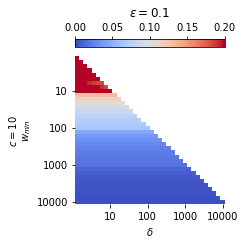

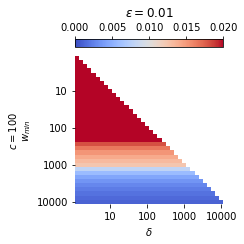

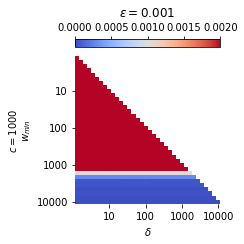

/home/felix/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: FutureWarning: Dropping invalid columns in DataFrameGroupBy.quantile is deprecated. In a future version, a TypeError will be raised. Before calling .quantile, select only columns which should be valid for the function.
  # Remove the CWD from sys.path while we load stuff.


0it [00:00, ?it/s]

/home/felix/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: FutureWarning: Dropping invalid columns in DataFrameGroupBy.quantile is deprecated. In a future version, a TypeError will be raised. Before calling .quantile, select only columns which should be valid for the function.
  # Remove the CWD from sys.path while we load stuff.


0it [00:00, ?it/s]

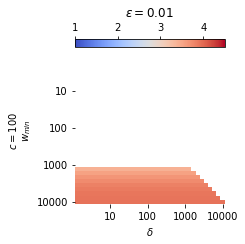

/home/felix/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: FutureWarning: Dropping invalid columns in DataFrameGroupBy.quantile is deprecated. In a future version, a TypeError will be raised. Before calling .quantile, select only columns which should be valid for the function.
  # Remove the CWD from sys.path while we load stuff.


0it [00:00, ?it/s]

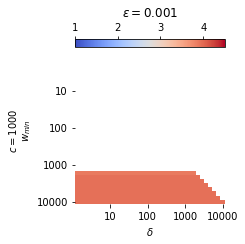

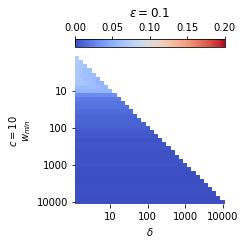

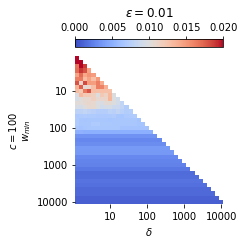

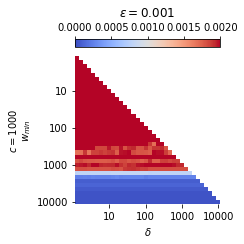

/home/felix/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: FutureWarning: Dropping invalid columns in DataFrameGroupBy.quantile is deprecated. In a future version, a TypeError will be raised. Before calling .quantile, select only columns which should be valid for the function.
  # Remove the CWD from sys.path while we load stuff.


0it [00:00, ?it/s]

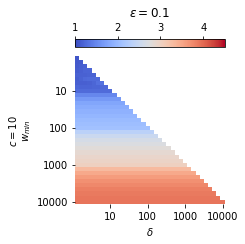

/home/felix/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: FutureWarning: Dropping invalid columns in DataFrameGroupBy.quantile is deprecated. In a future version, a TypeError will be raised. Before calling .quantile, select only columns which should be valid for the function.
  # Remove the CWD from sys.path while we load stuff.


0it [00:00, ?it/s]

/home/felix/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: FutureWarning: Dropping invalid columns in DataFrameGroupBy.quantile is deprecated. In a future version, a TypeError will be raised. Before calling .quantile, select only columns which should be valid for the function.
  # Remove the CWD from sys.path while we load stuff.


0it [00:00, ?it/s]

classification val


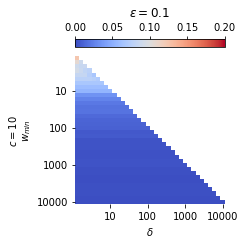

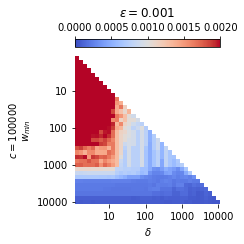

/home/felix/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: FutureWarning: Dropping invalid columns in DataFrameGroupBy.quantile is deprecated. In a future version, a TypeError will be raised. Before calling .quantile, select only columns which should be valid for the function.
  # Remove the CWD from sys.path while we load stuff.


0it [00:00, ?it/s]

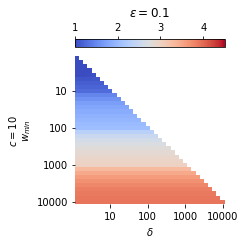

/home/felix/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: FutureWarning: Dropping invalid columns in DataFrameGroupBy.quantile is deprecated. In a future version, a TypeError will be raised. Before calling .quantile, select only columns which should be valid for the function.
  # Remove the CWD from sys.path while we load stuff.


0it [00:00, ?it/s]

/home/felix/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: FutureWarning: Dropping invalid columns in DataFrameGroupBy.quantile is deprecated. In a future version, a TypeError will be raised. Before calling .quantile, select only columns which should be valid for the function.
  # Remove the CWD from sys.path while we load stuff.


0it [00:00, ?it/s]

regression oob


/home/felix/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: FutureWarning: Dropping invalid columns in DataFrameGroupBy.quantile is deprecated. In a future version, a TypeError will be raised. Before calling .quantile, select only columns which should be valid for the function.
  # Remove the CWD from sys.path while we load stuff.


0it [00:00, ?it/s]

/home/felix/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: FutureWarning: Dropping invalid columns in DataFrameGroupBy.quantile is deprecated. In a future version, a TypeError will be raised. Before calling .quantile, select only columns which should be valid for the function.
  # Remove the CWD from sys.path while we load stuff.


0it [00:00, ?it/s]

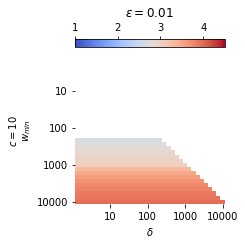

/home/felix/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: FutureWarning: Dropping invalid columns in DataFrameGroupBy.quantile is deprecated. In a future version, a TypeError will be raised. Before calling .quantile, select only columns which should be valid for the function.
  # Remove the CWD from sys.path while we load stuff.


0it [00:00, ?it/s]

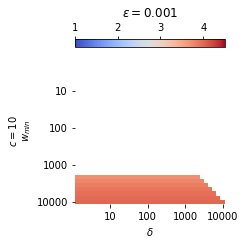

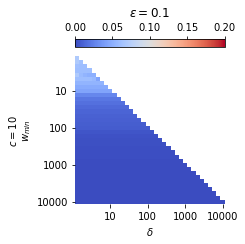

/home/felix/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: FutureWarning: Dropping invalid columns in DataFrameGroupBy.quantile is deprecated. In a future version, a TypeError will be raised. Before calling .quantile, select only columns which should be valid for the function.
  # Remove the CWD from sys.path while we load stuff.


0it [00:00, ?it/s]

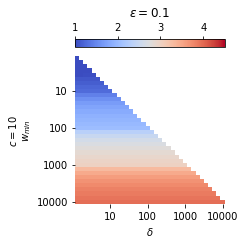

/home/felix/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: FutureWarning: Dropping invalid columns in DataFrameGroupBy.quantile is deprecated. In a future version, a TypeError will be raised. Before calling .quantile, select only columns which should be valid for the function.
  # Remove the CWD from sys.path while we load stuff.


0it [00:00, ?it/s]

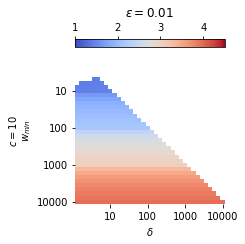

/home/felix/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: FutureWarning: Dropping invalid columns in DataFrameGroupBy.quantile is deprecated. In a future version, a TypeError will be raised. Before calling .quantile, select only columns which should be valid for the function.
  # Remove the CWD from sys.path while we load stuff.


0it [00:00, ?it/s]

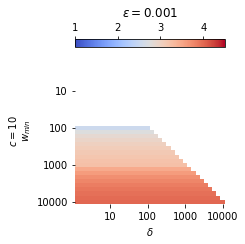

regression val


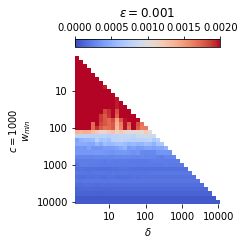

/home/felix/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: FutureWarning: Dropping invalid columns in DataFrameGroupBy.quantile is deprecated. In a future version, a TypeError will be raised. Before calling .quantile, select only columns which should be valid for the function.
  # Remove the CWD from sys.path while we load stuff.


0it [00:00, ?it/s]

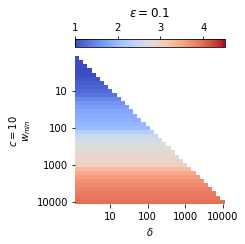

/home/felix/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: FutureWarning: Dropping invalid columns in DataFrameGroupBy.quantile is deprecated. In a future version, a TypeError will be raised. Before calling .quantile, select only columns which should be valid for the function.
  # Remove the CWD from sys.path while we load stuff.


0it [00:00, ?it/s]

/home/felix/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: FutureWarning: Dropping invalid columns in DataFrameGroupBy.quantile is deprecated. In a future version, a TypeError will be raised. Before calling .quantile, select only columns which should be valid for the function.
  # Remove the CWD from sys.path while we load stuff.


0it [00:00, ?it/s]

In [22]:
for problem_type in ["classification", "regression"]:
    for criterion in ["oob", "val"]:
        print(problem_type, criterion)
        create_selected_hpo_plots(problem_type, criterion)

In [48]:
def compute_hpo_sensitivity_results(problem_type):
    
    out_file = f"results_{problem_type}_sensitivity_hpo.csv"
    
    if not os.path.exists(out_file):
            
        
        def reduce(df):
            
            df = df[df["bootstrap_repeats"] == 0]
            
            mask = np.zeros(len(df), dtype=bool)
            for eps in [0.1, 0.01, 0.001]:
                wmin, delta, c = get_hpo_for_epsilon(eps, problem_type, "val")
                cond1 = df["epsilon"] == eps
                cond2 = df["w_min"] == wmin
                cond3 = df["delta"] == delta
                cond4 = df["c"] == c
                mask = [b1 | b2 for b1, b2 in zip(mask, (cond1 & cond2 & cond3 & cond4))]
                print("\t", np.count_nonzero(mask))
            print(f"Reducing dataframe from {len(df)} entries to {np.count_nonzero(mask)} entries.")
            return df[mask]
        
        # write result away
        df = pd.concat([
            reduce(pd.read_csv(f"results_{problem_type}_sensitivity_summary_oob.csv")),
            reduce(pd.read_csv(f"results_{problem_type}_sensitivity_summary_val.csv"))
        ])
        
        print(f"Ready, writing results to {out_file}")
        df.to_csv(out_file, index=False)
        
compute_hpo_sensitivity_results("classification")
compute_hpo_sensitivity_results("regression")

# RQ3: Computational Overhead

In [28]:
df_sensitivity_classification_hpo = pd.read_csv("results_classification_sensitivity_hpo.csv")
df_sensitivity_regression_hpo = pd.read_csv("results_regression_sensitivity_hpo.csv")

for df in [df_sensitivity_classification_hpo, df_sensitivity_regression_hpo]:
    df["time_reason"] = df["reasoning_time_per_tree_in_ns"] * df["num_trees"]
    step_sizes = np.minimum(df["w_min"] - 1, np.minimum(100, np.maximum(10, df["c"] / 10**2))).astype(int)
    df["time_reason"] *= step_sizes
    

In [29]:
df_sensitivity_classification_hpo

openmlid target_type  epsilon  w_min  delta       c  bootstrap_repeats  \
0            3         oob    0.001    100    100  100000                  0   
1            3         oob    0.010    100    100     100                  0   
2            3         oob    0.100      3      3      10                  0   
3            6         oob    0.001    100    100  100000                  0   
4            6         oob    0.010    100    100     100                  0   
...        ...         ...      ...    ...    ...     ...                ...   
1321     42733         val    0.010    100    100     100                  0   
1322     42733         val    0.100      3      3      10                  0   
1323     42734         val    0.001    100    100  100000                  0   
1324     42734         val    0.010    100    100     100                  0   
1325     42734         val    0.100      3      3      10                  0   

          seed    num_trees  reasoning_time_per_tree_in_ns  score_oob  \
0     4.500000  3207.600000                       2.000000   0.026170   
1     4.500000   235.000000                       4.400000   0.044030   
2     4.500000    13.400000                      57.400000   0.170300   
3     4.500000  4375.800000                       2.100000   0.118630   
4     4.500000   270.000000                       5.300000   0.143490   
...        ...          ...                            ...        ...   
1321  4.777778   110.000000                       5.000000   0.295522   
1322  4.777778     6.000000                      72.111111   0.455689   
1323  4.555556  1507.000000                       2.000000   0.367911   
1324  4.555556   133.333333                       5.333333   0.395789   
1325  4.555556     8.000000                      68.555556   0.574489   

      score_val   gap_oob   gap_val    time_train     time_pred    time_score  \
0      0.022160  0.001930  0.000092  6.457512e+06  1.511989e+06  2.234767e+05   
1      0.022770  0.019790  0.000702  4.731065e+05  1.107692e+05  1.637290e+04   
2      0.033440  0.146060  0.011372  2.697648e+04  6.316420e+03  9.335000e+02   
3      0.110690  0.002820  0.000006  6.939647e+07  7.931621e+06  3.526528e+06   
4      0.112320  0.027680  0.001636  4.281819e+06  4.893453e+05  2.176119e+05   
...         ...       ...       ...           ...           ...           ...   
1321   0.287033  0.011722 -0.000771  9.248577e+07  1.774640e+06  2.423178e+04   
1322   0.289489  0.171889  0.001684  5.044678e+06  9.679853e+04  1.321733e+03   
1323   0.360356  0.004800  0.000353  6.264627e+08  6.354248e+06  4.411495e+05   
1324   0.363189  0.032678  0.003187  5.571447e+07  5.648863e+05  3.923433e+04   
1325   0.409656  0.211378  0.049653  3.339379e+06  3.386347e+04  2.351911e+03   

        time_reason  
0     635104.800000  
1      10340.000000  
2       1538.320000  
3     909728.820000  
4      14310.000000  
...             ...  
1321    5500.000000  
1322     865.333333  
1323  298386.000000  
1324    7111.111111  
1325    1096.888889  

[1326 rows x 18 columns]

In [30]:
def enhance_asrfdf_by_overheads(df):
    df_runtimes = df.copy()
    df_runtimes["overhead_abs"] = (df_runtimes["time_pred"] + df_runtimes["time_score"] + df_runtimes["time_reason"])
    df_runtimes["overhead_per_tree_abs"] = df_runtimes["overhead_abs"] / df_runtimes["num_trees"]
    df_runtimes["overhead_per_tree_rel"] = df_runtimes["overhead_per_tree_abs"] / (df_runtimes["time_train"] / df_runtimes["num_trees"])
    df_runtimes["portion_pred"] = np.round(df_runtimes["time_pred"] / df_runtimes["num_trees"] / df_runtimes["overhead_per_tree_abs"], 2)
    df_runtimes["portion_score"] = np.round(df_runtimes["time_score"] / df_runtimes["num_trees"] / df_runtimes["overhead_per_tree_abs"], 2)
    df_runtimes["portion_reason"] = np.round(df_runtimes["time_reason"] / df_runtimes["num_trees"] / df_runtimes["overhead_per_tree_abs"], 2)
    return df_runtimes

In [31]:
df_sensitivity_classification_hpo_with_overhead = enhance_asrfdf_by_overheads(df_sensitivity_classification_hpo)
df_sensitivity_classification_hpo_with_overhead

openmlid target_type  epsilon  w_min  delta       c  bootstrap_repeats  \
0            3         oob    0.001    100    100  100000                  0   
1            3         oob    0.010    100    100     100                  0   
2            3         oob    0.100      3      3      10                  0   
3            6         oob    0.001    100    100  100000                  0   
4            6         oob    0.010    100    100     100                  0   
...        ...         ...      ...    ...    ...     ...                ...   
1321     42733         val    0.010    100    100     100                  0   
1322     42733         val    0.100      3      3      10                  0   
1323     42734         val    0.001    100    100  100000                  0   
1324     42734         val    0.010    100    100     100                  0   
1325     42734         val    0.100      3      3      10                  0   

          seed    num_trees  reasoning_time_per_tree_in_ns  ...    time_train  \
0     4.500000  3207.600000                       2.000000  ...  6.457512e+06   
1     4.500000   235.000000                       4.400000  ...  4.731065e+05   
2     4.500000    13.400000                      57.400000  ...  2.697648e+04   
3     4.500000  4375.800000                       2.100000  ...  6.939647e+07   
4     4.500000   270.000000                       5.300000  ...  4.281819e+06   
...        ...          ...                            ...  ...           ...   
1321  4.777778   110.000000                       5.000000  ...  9.248577e+07   
1322  4.777778     6.000000                      72.111111  ...  5.044678e+06   
1323  4.555556  1507.000000                       2.000000  ...  6.264627e+08   
1324  4.555556   133.333333                       5.333333  ...  5.571447e+07   
1325  4.555556     8.000000                      68.555556  ...  3.339379e+06   

         time_pred    time_score    time_reason  overhead_abs  \
0     1.511989e+06  2.234767e+05  635104.800000  2.370571e+06   
1     1.107692e+05  1.637290e+04   10340.000000  1.374821e+05   
2     6.316420e+03  9.335000e+02    1538.320000  8.788240e+03   
3     7.931621e+06  3.526528e+06  909728.820000  1.236788e+07   
4     4.893453e+05  2.176119e+05   14310.000000  7.212672e+05   
...            ...           ...            ...           ...   
1321  1.774640e+06  2.423178e+04    5500.000000  1.804372e+06   
1322  9.679853e+04  1.321733e+03     865.333333  9.898560e+04   
1323  6.354248e+06  4.411495e+05  298386.000000  7.093783e+06   
1324  5.648863e+05  3.923433e+04    7111.111111  6.112318e+05   
1325  3.386347e+04  2.351911e+03    1096.888889  3.731227e+04   

      overhead_per_tree_abs  overhead_per_tree_rel  portion_pred  \
0                739.048148               0.367103          0.64   
1                585.030213               0.290594          0.81   
2                655.838806               0.325774          0.72   
3               2826.426697               0.178221          0.64   
4               2671.360000               0.168449          0.68   
...                     ...                    ...           ...   
1321           16403.377778               0.019510          0.98   
1322           16497.600000               0.019622          0.98   
1323            4707.221898               0.011324          0.90   
1324            4584.238333               0.010971          0.92   
1325            4664.033333               0.011173          0.91   

      portion_score  portion_reason  
0              0.09            0.27  
1              0.12            0.08  
2              0.11            0.18  
3              0.29            0.07  
4              0.30            0.02  
...             ...             ...  
1321           0.01            0.00  
1322           0.01            0.01  
1323           0.06            0.04  
1324           0.06            0.01  
1325           0.06            0.03  

[1326 rows x 24 c

In [32]:
df_sensitivity_regression_hpo_with_overhead = enhance_asrfdf_by_overheads(df_sensitivity_regression_hpo)
df_sensitivity_regression_hpo_with_overhead

openmlid target_type  epsilon  w_min  delta     c  bootstrap_repeats  \
0           8         oob    0.001    100    100  1000                  0   
1           8         oob    0.010     10     10   100                  0   
2           8         oob    0.100      2      2    10                  0   
3         189         oob    0.001    100    100  1000                  0   
4         189         oob    0.010     10     10   100                  0   
..        ...         ...      ...    ...    ...   ...                ...   
343     42731         val    0.010     10     10   100                  0   
344     42731         val    0.100      2      2    10                  0   
345     43071         val    0.001    100    100  1000                  0   
346     43071         val    0.010     10     10   100                  0   
347     43071         val    0.100      2      2    10                  0   

     seed  num_trees  reasoning_time_per_tree_in_ns  ...   time_train  \
0     4.5      711.0                           10.9  ...    902315.30   
1     4.5       56.7                           16.6  ...     71934.75   
2     4.5        3.5                          138.9  ...      4442.42   
3     4.5     1482.0                           12.6  ...  39693374.00   
4     4.5       99.9                           14.8  ...   2675702.07   
..    ...        ...                            ...  ...          ...   
343   4.5       27.0                           18.2  ...   3436325.91   
344   4.5        4.0                          135.5  ...    509085.32   
345   4.5      233.0                            6.1  ...   4324539.40   
346   4.5       38.7                           17.0  ...    717952.50   
347   4.5        4.6                          130.4  ...     85436.34   

      time_pred  time_score  time_reason  overhead_abs  overhead_per_tree_abs  \
0     182348.40    44963.20     77499.00     304810.60             428.706892   
1      14538.06     3585.96      8470.98      26595.00             469.047619   
2        897.62      220.82       486.15       1604.59             458.454286   
3    1028939.40   181599.30    186732.00    1397270.70             942.827733   
4      69343.56    12249.09     13306.68      94899.33             949.943243   
..          ...         ...          ...           ...                    ...   
343    32664.33     5366.79      4422.60      42453.72            1572.360000   
344     4839.16      795.08       542.00       6176.24            1544.060000   
345    27491.20    14064.10     14213.00      55768.30             239.348927   
346     4569.21     2339.73      5921.10      12830.04             331.525581   
347      543.26      277.96       599.84       1421.06             308.926087   

     overhead_per_tree_rel  portion_pred  portion_score  portion_reason  
0                 0.337809          0.60           0.15            0.25  
1                 0.369710          0.55           0.13            0.32  
2                 0.361197          0.56           0.14            0.30  
3                 0.035202          0.74           0.13            0.13  
4                 0.035467          0.73           0.13            0.14  
..                     ...           ...            ...             ...  
343               0.012354          0.77           0.13            0.10  
344               0.012132          0.78           0.13            0.09  
345               0.012896          0.49           0.25            0.25  
346               0.017870          0.36           0.18            0.46  
347               0.016633          0.38           0.20            0.42  

[348 rows x 24 columns]

## Time Invested for Reasoning

In [33]:
def plot_overhead_analysis(df, problem_type):
    fig, axs = plt.subplots(2, 4, figsize=(12, 5))
    for (target_type, df_type), axrow in zip(df.groupby("target_type"), axs):
        epsilons = []
        overheads_abs = []
        overheads_abs_total = []
        overheads_rel = []
        for eps in EPS_LIST:
            df_eps = df_type[df_type["epsilon"] == eps]
            epsilons.append(eps)
            overheads_abs_total.append(df_eps["overhead_abs"].values / 10**6)
            overheads_abs.append(df_eps["overhead_per_tree_abs"].values / 10**3)
            overheads_rel.append(df_eps["overhead_per_tree_rel"].values)

        name = "Validation Curve" if target_type == "val" else "OOB Curve"
        problem_type_name = 'Classification' if problem_type == 'classification' else 'Regression'
        name = f"{problem_type_name} {name}"

        ax = axrow[0]
        threshold = 10**4
        if np.max(overheads_abs) > threshold:
            raise Exception(f"Highest value among absolute overheads bigger than {threshold}, increase threshold in code.")
        ax.boxplot(overheads_abs_total)
        ax.axhline(1, color="black", linewidth=1)
        ax.set_title(f"{name}\nAbsolute overhead in s")
        ax.set_yscale("log")
        ax.set_ylim([10**-3, threshold])
        ax.set_xlabel("$\\varepsilon$")
        
        ax = axrow[1]
        threshold = 10**3.5
        if np.max(overheads_abs) > threshold:
            raise Exception(f"Highest value among absolute overheads bigger than {threshold}, increase threshold in code.")
        ax.boxplot(overheads_abs)
        ax.set_title(f"{name}\nAbs. overhead/tree in ms")
        ax.axhline(1, linestyle="--", color="blue", linewidth=1)
        ax.axhline(10, linestyle="--", color="green", linewidth=1)
        ax.axhline(100, linestyle="--", color="orange", linewidth=1)
        ax.axhline(1000, linestyle="--", color="red", linewidth=1)
        ax.set_yscale("log")
        ax.set_ylim([10**-1, threshold])
        ax.set_xlabel("$\\varepsilon$")

        ax = axrow[2]
        threshold = 0.7
        ax.boxplot(overheads_rel)
        if np.max(overheads_rel) > threshold:
            raise Exception(f"Highest value among relative overheads bigger than {threshold}, increase threshold in code.")
        ax.set_title(f"{name}\nOverhead divided by train time")
        ax.set_ylim([0, threshold])
        ax.set_xlabel("$\\varepsilon$")
        
        for ax in axrow[:3]:
            ax.set_xticklabels(epsilons)

        ax = axrow[3]
        ax.boxplot([
            df["portion_pred"],
            df["portion_score"],
            df["portion_reason"]
        ])
        ax.set_title(f"{name}\nPortions of Overhead by Task")
        ax.set_xticklabels(["predictions", "score", "reasoning"], rotation = 0)
    fig.tight_layout()
    plt.subplots_adjust(wspace=0.2)
    fig.savefig(f"plots/runtime_overview_{problem_type}.pdf", bbox_inches="tight")
    plt.show()
    
    # comparison between absolute and relative gaps
    df_red = df[df["epsilon"] == 0.01]
    fig, ax = plt.subplots()
    threshold_abs = 2 * 10**3
    threshold_rel = 0.7
    if np.max(df_red["overhead_per_tree_rel"]) > threshold_rel:
        raise Exception(f"Highest value among relative overheads bigger than {threshold_rel}, increase threshold in code.")
    if np.max(df_red["overhead_per_tree_abs"]) > threshold_abs * 10**3:
        raise Exception(f"Highest value among absolute overheads bigger than {threshold_abs}, increase threshold in code.")
    
    for target_type, df_sub in df_red.groupby("target_type"):
        ax.scatter(df_sub["overhead_per_tree_rel"].values, df_sub["overhead_per_tree_abs"].values / 10**3, s=5, alpha=0.5, label=target_type)
    ax.set_yscale("log")
    ax.set_xlabel("Relative Overhead compared to training time")
    ax.set_ylabel("Absolute Overhead (ms)")
    ax.axhline(1, linestyle="--", color="blue", linewidth=1)
    ax.axhline(10, linestyle="--", color="green", linewidth=1)
    ax.axhline(100, linestyle="--", color="orange", linewidth=1)
    ax.axhline(1000, linestyle="--", color="red", linewidth=1)
    ax.set_xlim([0, threshold_rel])
    ax.set_ylim([10**-1, threshold_abs])
    ax.legend()
    ax.set_title(f"Absolute vs. Relative Total Overhead per Tree ({problem_type_name})")
    fig.savefig(f"plots/runtime_abs_vs_rel_{problem_type}.pdf", bbox_inches="tight")
    plt.show()

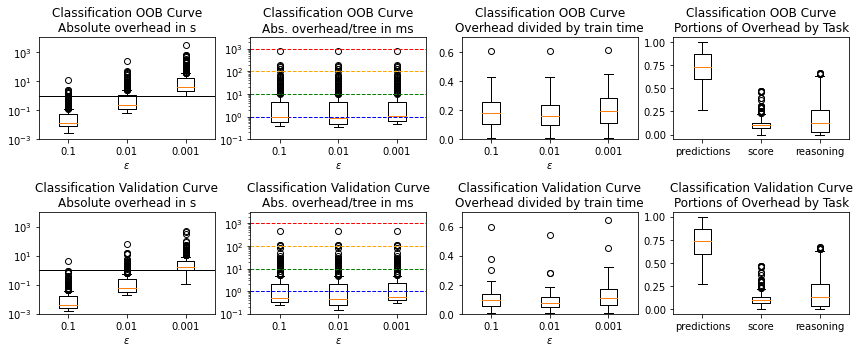

In [34]:
plot_overhead_analysis(df_sensitivity_classification_hpo_with_overhead, "classification")

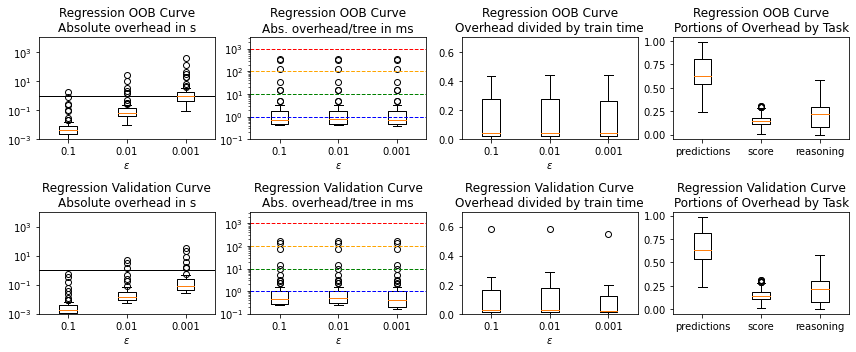

In [89]:
plot_overhead_analysis(df_sensitivity_regression_hpo_with_overhead, "regression")

In [40]:
np.round(df_sensitivity_classification_hpo_with_overhead.groupby("target_type")["overhead_per_tree_rel"].mean(), 2)

target_type
oob    0.19
val    0.10
Name: overhead_per_tree_rel, dtype: float64

In [41]:
np.round(df_sensitivity_regression_hpo_with_overhead.groupby("target_type")["overhead_per_tree_rel"].mean(), 2)

target_type
oob    0.13
val    0.08
Name: overhead_per_tree_rel, dtype: float64

# RQ4: Number of Trees Built

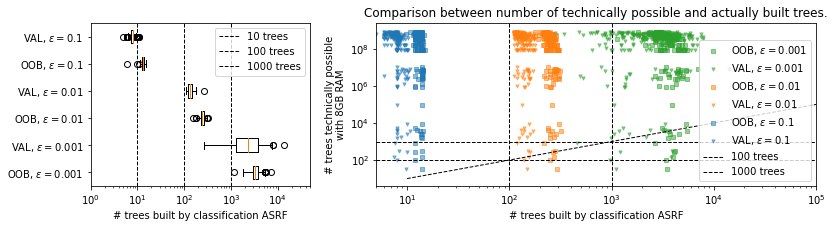

Average number of trees build in classification for the different epsilon: epsilon  target_type
0.001    oob            3456.551083
         val            2739.654703
0.010    oob             247.137381
         val             135.349278
0.100    oob              13.135757
         val               7.942570
Name: num_trees, dtype: float64
Average number of trees when using validation curve compared to OOB curve for the different epsilons: [nan nan nan nan nan nan]


/home/felix/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:63: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.


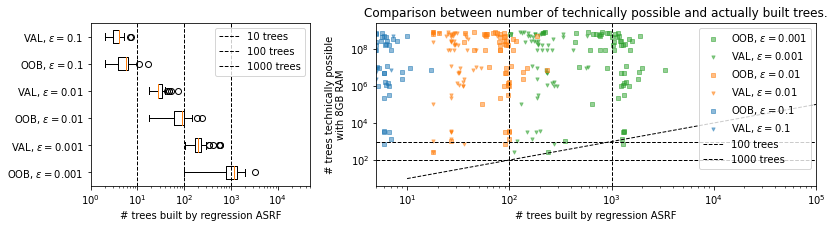

Average number of trees build in regression for the different epsilon: epsilon  target_type
0.001    oob            1093.896552
         val             222.948276
0.010    oob              83.963793
         val              30.227586
0.100    oob               5.493103
         val               3.696552
Name: num_trees, dtype: float64
Average number of trees when using validation curve compared to OOB curve for the different epsilons: [nan nan nan nan nan nan]


/home/felix/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:63: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.


In [66]:
def plot_number_of_trees_analysis(df_base, df_sensitivity, problem_type):
        
    #plot_number_of_tree_distributions(df_sensitivity_classification_hpo_with_overhead)
    df_base_reduced = df_base[["openmlid", "seed", "max_trees_8", "max_trees_16"]].groupby("openmlid").mean().reset_index().drop(columns=["seed"])
    df_analysis = df_sensitivity[["openmlid", "target_type", "epsilon", "num_trees"]].merge(df_base_reduced, on="openmlid")
    fig, axs = plt.subplots(1, 2, figsize=(13, 3), gridspec_kw={'width_ratios': [1, 2]})
    
    def get_label(target_type, eps):
        return f"{target_type.upper()}, $\\varepsilon = {eps}$"
        
    
    epsilon_domain = EPS_LIST

    ax = axs[0]
    ticknames, dfs = zip(*df_analysis.groupby(["epsilon", "target_type"]))
    ax.boxplot([df["num_trees"] for df in dfs], vert=False)
    ax.axvline(10**1, color="black", linestyle="--", label="10 trees", linewidth=1)
    ax.axvline(10**2, color="black", linestyle="--", label="100 trees", linewidth=1)
    ax.axvline(10**3, color="black", linestyle="--", label="1000 trees", linewidth=1)
    ax.set_yticklabels([get_label(c[1], c[0]) for c in ticknames])
    ax.set_xscale("log")
    ax.set_xlabel(f"# trees built by {problem_type} ASRF")
    ax.set_xlim([1, 5*10**4])
    ax.legend()

    ax = axs[1]
    for ((eps, target_type), df) in zip(ticknames, dfs):
        i = epsilon_domain.index(eps)
        m = "s" if target_type == "oob" else "v"
        ax.scatter(df["num_trees"], df["max_trees_8"], s=10, color=f"C{i}", label=get_label(target_type, eps), marker = m, alpha=0.5)
    ax.set_xscale("log")
    ax.set_xlim([5, 10**5])
    ax.set_yscale("log")
    ax.plot([10**1, 10**9], [10**1, 10**9], color="black", linestyle="--", linewidth=1)
    ax.axhline(10**2, color="black", linestyle="--", label="100 trees", linewidth=1)
    ax.axvline(10**2, color="black", linestyle="--", linewidth=1)
    ax.axhline(10**3, color="black", linestyle="--", label="1000 trees", linewidth=1)
    ax.axvline(10**3, color="black", linestyle="--", linewidth=1)
    ax.set_xlabel(f"# trees built by {problem_type} ASRF")
    ax.set_ylabel("# trees technically possible\nwith 8GB RAM")
    ax.set_title(f"Comparison between number of technically possible and actually built trees.")
    ax.legend()

    #ax = axs[2]
    #ax.boxplot([df["max_trees_8"] / df["num_trees"] for df in dfs])
    #ax.axhline(1, color="black", linestyle="--", linewidth=1)
    #ax.set_yscale("log")
    #ax.set_xticklabels(ticknames)
    #ax.set_xlabel("$\\varepsilon$")
    #ax.set_title("Ratio between the number of\ntechnically possible (with 8GB RAM)\nand actually built trees")
    #fig.tight_layout()
    
    fig.savefig(f"plots/numtrees_analysis_{problem_type}.pdf", bbox_inches="tight")
    plt.show()
    
for df_base, df_sensitivity, key in [
    (df_base_classification, df_sensitivity_classification_hpo, "classification"),
    (df_base_regression, df_sensitivity_regression_hpo, "regression")
    ]:
    plot_number_of_trees_analysis(df_base, df_sensitivity, key)
    print(f"Average number of trees build in {key} for the different epsilon:", df_sensitivity.groupby(["epsilon", "target_type"]).mean()["num_trees"])
    print(f"Average number of trees when using validation curve compared to OOB curve for the different epsilons:", np.round([df[df["target_type"] == "val"].mean()["num_trees"] / df[df["target_type"] == "oob"].mean()["num_trees"] for eps, df in df_sensitivity.groupby(["epsilon", "target_type"])], 2))

In [76]:
df_base_classification.query("max_trees_8 < 100")[["openmlid", "max_trees_8"]].groupby("openmlid").mean().reset_index().merge(df_metadata, on="openmlid")

openmlid  max_trees_8    name  instances  features  numeric features  \
0     41167         31.0  dionis     416188        60                60   

   classes  % missing  
0      355          0

# RQ5: What is the resulting difference in performance between ASRF and a RF with a fixed number of trees?

classification oob 0.1 ASRF is better (and probably trains more trees) than max trees on 1 datasets. max trees inadmissible on 0 datasets: []
Datasets for which ASRF is better than max trees: [741]
classification oob 0.01 ASRF is better (and probably trains more trees) than max trees on 7 datasets. max trees inadmissible on 1 datasets: [41167]
Datasets for which ASRF is better than max trees: [61, 154, 741, 752, 1569, 41167, 41169]
classification oob 0.001 ASRF is better (and probably trains more trees) than max trees on 43 datasets. max trees inadmissible on 5 datasets: [154, 354, 1569, 41167, 41169]
Datasets for which ASRF is better than max trees: [18, 23, 26, 154, 180, 183, 184, 273, 293, 351, 354, 390, 395, 715, 735, 741, 803, 822, 897, 903, 917, 1000, 1037, 1039, 1050, 1067, 1216, 1489, 1569, 4135, 4136, 4541, 23380, 40497, 40691, 40975, 40982, 40983, 41065, 41166, 41167, 41168, 41169]
classification val 0.1 ASRF is better (and probably trains more trees) than max trees on 1 data

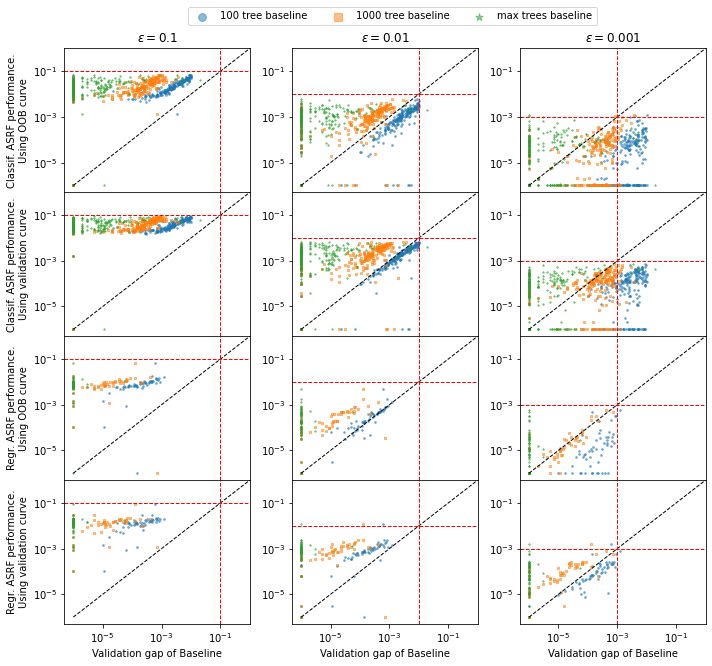

In [85]:
def plot_performance_diference(df_base, df_sensitivity, problem_type, criterion, axs = None):
    
    # here we are *only* interested in the validation performance (even if the *decision criterion* is OOB)
    df_100 = get_results_for_number_of_trees(df_base, num_trees = 100, target_type = None, suffix="_100").groupby("openmlid").mean().reset_index()[["openmlid", f"gap_val_100"]]
    df_1000 = get_results_for_number_of_trees(df_base, num_trees = 1000, target_type = None, suffix="_1000").groupby("openmlid").mean().reset_index()[["openmlid", f"gap_val_1000"]]
    df_max =  get_results_for_number_of_trees(df_base, num_trees = df_base.rename(columns={"max_trees_8": "num_trees"})[["openmlid", "seed", "num_trees"]], target_type = None, suffix="_max").groupby("openmlid").mean().reset_index()[["openmlid", f"gap_val_max"]]
    df_asrf = df_sensitivity.query("target_type == '" + criterion + "'")[["openmlid", "epsilon", f"gap_val"]] # 
    df_plot = df_100.merge(df_1000, on="openmlid").merge(df_max, on="openmlid").merge(df_asrf, on="openmlid")
    df_plot = df_plot.copy()
    
    for col in df_plot.columns:
        if "gap_" in col:
            df_plot[col] = np.maximum(10**-6, df_plot[col])
    
    if axs is None:
        fig, axs = plt.subplots(1, 3, figsize=(12, 3))
    else:
        fig = None
    
    for ax, eps in zip(axs, EPS_LIST):
        df_eps = df_plot[df_plot["epsilon"] == eps]
        ax.scatter(df_eps[f"gap_val_100"], df_eps[f"gap_val"], s=3, marker="o", alpha=0.5, label="100 tree baseline")
        ax.scatter(df_eps[f"gap_val_1000"], df_eps[f"gap_val"], s=3, marker="s", alpha=0.5, label="1000 tree baseline")
        ax.scatter(df_eps[f"gap_val_max"], df_eps[f"gap_val"], s=3, marker="*", alpha=0.5, label="max trees baseline")
        
        asrf_beats_max = df_eps[f"gap_val_max"] > df_eps[f"gap_val"] + 10**-6
        max_inadmissible = df_eps[f"gap_val_max"] > eps
        print(problem_type, criterion, eps, f"ASRF is better (and probably trains more trees) than max trees on {np.count_nonzero(asrf_beats_max)} datasets.", f"max trees inadmissible on {np.count_nonzero(max_inadmissible)} datasets: {list(df_eps[max_inadmissible]['openmlid'])}")
        print(f"Datasets for which ASRF is better than max trees: {list(df_eps[asrf_beats_max]['openmlid'])}")
        
        #lower_limit_x = min(np.maximum(10**-10, np.maximum(df_eps[f"gap_{criterion}_100"], df_eps[f"gap_{criterion}_1000"]) / 10))
        #upper_limit_x = max(np.maximum(10**-10, np.maximum(df_eps[f"gap_{criterion}_100"], df_eps[f"gap_{criterion}_1000"]) * 10))
        #lower_limit_y = min(np.maximum(10**-10, df_eps[f"gap_{criterion}"]))
        #upper_limit_y = max(np.maximum(10**-10, df_eps[f"gap_{criterion}"])) * 10
        lower_limit_x = lower_limit_y = 10**-6
        upper_limit_x = upper_limit_y = 10**0
        ax.plot([lower_limit_y, upper_limit_y], [lower_limit_y, upper_limit_y], color="black", linestyle="--", linewidth=1)
        #ax.set_xlim([lower_limit_x, upper_limit_x])
        #ax.set_ylim([lower_limit_y, upper_limit_y])
        
        ax.axhline(eps, color="red", linestyle="--", linewidth=1)
        ax.axvline(eps, color="red", linestyle="--", linewidth=1)
        #ax.plot([10**2, 10**6], [10**3, 10**7], color="red", linestyle="--", linewidth=1)
        #ax.plot([10**2, 10**6], [5*10**2, 5*10**6], color="orange", linestyle="--", linewidth=1)
        #ax.plot([10**2, 10**6], [2*10**2, 2*10**6], color="green", linestyle="--", linewidth=1)
        ax.set_xscale("log")
        ax.set_yscale("log")
        ax.set_xlabel("Validation gap of Baseline")
        ax.set_ylabel("Validation gap of ASRF")
        #ax.legend()
        ax.set_title(f"$\\varepsilon = {eps}$, {problem_type}, {criterion}")
    
    return fig
    
    
fig, axs = plt.subplots(4, 3, figsize=(10, 9), sharex=False)

i = 0

for problem_type, df_base, df_sensitivity in zip(["classification", "regression"], [df_base_classification, df_base_regression], [df_sensitivity_classification_hpo_with_overhead, df_sensitivity_regression_hpo_with_overhead]):
    
    for criterion in ["oob", "val"]:
        plot_performance_diference(df_base, df_sensitivity, problem_type, criterion, axs=axs[i])
        if i < 4:
            for j, ax in enumerate(axs[i]):
                ax.set_title(f"$\\varepsilon = {EPS_LIST[j]}$" if i == 0 else None)
                if i < 3:
                    ax.set_xticks([])
                    ax.set_xlabel(None)
        
        problem_type_name = "Classif." if problem_type == "classification" else "Regr."
        criterion_name = "OOB" if criterion == "oob" else "validation"
        for j, ax in enumerate(axs[i]):
            eps = EPS_LIST[j]
            ax.set_ylabel(f"{problem_type_name} ASRF performance.\nUsing {criterion_name} curve" if j == 0 else None)
            ax.set_xlim([5*10**-7, 1])
            ax.set_ylim([5*10**-7, 1])
        i += 1
        
fig.tight_layout()
handles, labels = axs[0,0].get_legend_handles_labels()
lgd = fig.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.55, 1.03), ncol=3)
for m in lgd.legendHandles:
    m._sizes = [60]
plt.subplots_adjust(hspace=0)
fig.savefig(f"plots/comparisons/performances.pdf", bbox_inches="tight")
plt.show()

# RQ6: What is the resulting difference in total training time between ASRF and a RF with a fixed number of trees?

## Absolute Comparison

In [86]:
def plot_runtime_differences(df_base, df_sensitivity, problem_type, criterion, axs = None):
    
    # since we only look at times here, the oob keyword in the following two statements has no effect. It could also be changed to val
    df_100 = get_results_for_number_of_trees(df_base, num_trees = 100, target_type = "oob", suffix="_100").groupby("openmlid").mean().reset_index()[["openmlid", "gap_val_100", "time_train_100"]]
    df_1000 = get_results_for_number_of_trees(df_base, num_trees = 1000, target_type = "oob", suffix="_1000").groupby("openmlid").mean().reset_index()[["openmlid", "gap_val_1000", "time_train_1000"]]
    df_max =  get_results_for_number_of_trees(df_base, num_trees = df_base.rename(columns={"max_trees_8": "num_trees"})[["openmlid", "seed", "num_trees"]], target_type = None, suffix="_max").groupby("openmlid").mean().reset_index()[["openmlid", "gap_val_max", "time_train_max"]]
    df_asrf = df_sensitivity.query("target_type == '" + criterion + "'")[["openmlid", "epsilon", "num_trees", "time_train", "reasoning_time_per_tree_in_ns", "time_pred", "time_score"]]
    df_asrf["time_asrf"] = (df_asrf["time_train"] + df_asrf["time_pred"] + df_asrf["time_score"] + df_asrf["num_trees"] * df_asrf["reasoning_time_per_tree_in_ns"])
    df_plot = df_100.merge(df_1000, on="openmlid").merge(df_max, on="openmlid").merge(df_asrf[["openmlid", "epsilon", "time_asrf"]], on="openmlid")
    
    df_plot = df_plot.copy()
    
    for c in df_plot.columns:
        if "time" in c:
            df_plot[c] /= 10**3
    
    
    if axs is None:
        fig, axs = plt.subplots(1, 3, figsize=(14, 3))
    else:
        fig = None
        
    for ax, eps in zip(axs, EPS_LIST):
        df_eps = df_plot[df_plot["epsilon"] == eps]
        for i, (baseline_key, marker) in enumerate(zip(["100", "1000", "max"], ["o", "s", "*"])):
            inadmissible_baseline_mask = df_eps[f"gap_val_{baseline_key}"] > eps
            ax.scatter(df_eps[inadmissible_baseline_mask][f"time_train_{baseline_key}"], df_eps[inadmissible_baseline_mask]["time_asrf"], s=20, marker=marker, facecolors="none", edgecolors=f"C{i}", alpha=0.5, label=f"{baseline_key} tree baseline (inadmissible)")
            ax.scatter(df_eps[~inadmissible_baseline_mask][f"time_train_{baseline_key}"], df_eps[~inadmissible_baseline_mask]["time_asrf"], s=20, marker=marker, color=f"C{i}", alpha=0.5, label=f"{baseline_key} tree baseline (admissible)")
        
        max_exceed = np.max(np.maximum(df_eps["time_asrf"] / df_eps["time_train_100"], df_eps["time_asrf"] / df_eps["time_train_1000"]))
        ax.plot([10**2, 10**6], [10**2, 10**6], color="black", linestyle="--", linewidth=1)
        if max_exceed > 5:
            ax.plot([10**2, 10**6], [10**3, 10**7], color="red", linestyle="--", linewidth=1, label="ASRF 10x slower")
        if max_exceed > 2:
            ax.plot([10**2, 10**6], [5*10**2, 5*10**6], color="orange", linestyle="--", linewidth=1, label="ASRF 5x slower")
        if max_exceed > 1:
            ax.plot([10**2, 10**6], [2*10**2, 2*10**6], color="green", linestyle="--", linewidth=1, label="ASRF 2x slower")
        ax.set_xscale("log")
        ax.set_yscale("log")
        ax.set_xlabel("Time to train fixed size forest")
        ax.set_ylabel("Full time to train and\nmake decisions inside ASRF")
        ax.set_title(f"$\\varepsilon = {eps}$, {problem_type}, {criterion}")
    
    return fig

fig, axs = plt.subplots(4, 3, figsize=(10, 9), sharex=True)

i = 0

for problem_type, df_base, df_sensitivity in zip(["classification", "regression"], [df_base_classification, df_base_regression], [df_sensitivity_classification_hpo_with_overhead, df_sensitivity_regression_hpo_with_overhead]):
    
    for criterion in ["oob", "val"]:
        plot_runtime_differences(df_base, df_sensitivity, problem_type, criterion, axs=axs[i])
        if i < 4:
            for j, ax in enumerate(axs[i]):
                ax.set_title(f"$\\varepsilon = {EPS_LIST[j]}$" if i == 0 else None)
                if i < 3:
                    ax.set_xticks([])
                    ax.set_xlabel(None)
        
        problem_type_name = "Classif." if problem_type == "classification" else "Regr."
        criterion_name = "OOB" if criterion == "oob" else "validation"
        for j, ax in enumerate(axs[i]):
            eps = EPS_LIST[j]
            ax.set_ylabel(f"{problem_type_name} ASRF runtime.\nUsing {criterion_name} curve" if j == 0 else None)
        i += 1

fig.tight_layout()
handles, labels = axs[0,0].get_legend_handles_labels()
lgd = fig.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.55, 1.08), ncol=3)
for m in lgd.legendHandles:
    m._sizes = [60]
plt.subplots_adjust(hspace=0)
fig.savefig(f"plots/comparisons/runtimes.pdf", bbox_inches="tight")
plt.show()